This file is part of BrainMolecularAtlas.

Copyright (c) 2021-2022 Blue Brain Project/EPFL 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt


import timeit
import numpy as np
from collections import Counter

from numpy.random import seed
from numpy.random import randint
from scipy.stats import ks_2samp
from scipy.stats import levene
from scipy.stats import fligner
from scipy.stats import kruskal
import scikit_posthocs as sp

import scipy.stats as ss
from scipy.stats import mannwhitneyu



import pickle as pkl



pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
from helper_functions import (
    split_df_column_list_to_multiple_rows,
    get_samples
)


In [6]:
# We also use functions from https://github.com/gcalmettes/bootstrap-tools/blob/master/code/bootstrap_routines.py 
# Copyright 2012 gcalmettes (gcalmettes@ucla.edu), BSD-style copyright and disclaimer apply
#!/usr/local/bin/python

from bootstrap_routines import (
    bootstrap,
    bootci,
    bootci_diff,
    bootpv
)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
sns.set_style('whitegrid',{'axes.grid':False})

In [4]:
with open('../data/6_df_processed.pkl','rb') as f:
    df = pkl.load(f)
print(len(df))
df["log_conc_uM_medNorm"]  = df["log_conc_uM_medNorm"].astype('float64')

df = df.reset_index(drop=True)

df['exp_conc'] = np.exp(df['log_conc_uM_medNorm'])


2131244


In [5]:
df = df.loc[(df['condition'].isin(['young', 'adult',  'control',  'WT','SORT'])) | (df['condition'].isna())]

df = df.reset_index(drop=True)

In [7]:
# for consistency, let's have also all the data from mgi jax GO 

# GO glycolysis
jaxGlycol = pd.read_csv('../data/glycolysis_mgi_jax_go_24april2019_1048.txt',sep='\t')
#jaxGlycol = pd.read_csv('/Users/polina/Documents/BBP_project/METABOLISM/2018_Polina_model/Polina_model/ProteinRULES/jax_mgi_GO_data_24april2019/glycolysis_mgi_jax_go_24april2019_1048.txt',sep='\t')

jaxGlycol = jaxGlycol.drop(columns=['Reference(s)'])
jaxGlycol = jaxGlycol.reset_index()
jaxGlycol.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 'Proteoform', 'Evidence', 'Inferred From','Reference(s)']
jaxGlycol['Symbol'] = jaxGlycol['Symbol'].str.upper()
jaxGlycol['Symbol'] = jaxGlycol['Symbol'].str.split(' ')
jaxGlycol = split_df_column_list_to_multiple_rows(jaxGlycol, target_column='Symbol')
jaxGlycol = jaxGlycol.drop(columns=['MGI Gene/Marker ID','Chr', 'Context', 'Evidence', 'Inferred From', 'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
jaxGlycol['functional category'] = 'glycolysis' #'glycolysis by Jax MGI'
print('GO Glycolysis: ',len(jaxGlycol))
### GO mito
jaxMito = pd.read_csv('../data/mito_allGenes_mgi_jax_go_24april2019_1048.txt',sep='\t')
#jaxMito = pd.read_csv('/Users/polina/Documents/BBP_project/METABOLISM/2018_Polina_model/Polina_model/ProteinRULES/jax_mgi_GO_data_24april2019/mito_allGenes_mgi_jax_go_24april2019_1048.txt',sep='\t')
jaxMito = jaxMito.drop(columns=['Reference(s)'])
jaxMito = jaxMito.reset_index()
jaxMito.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 'Proteoform', 'Evidence', 'Inferred From','Reference(s)']
jaxMito['Symbol'] = jaxMito['Symbol'].str.upper()
jaxMito['Symbol'] = jaxMito['Symbol'].str.split(' ')
jaxMito = split_df_column_list_to_multiple_rows(jaxMito, target_column='Symbol')
jaxMito = jaxMito.drop(columns=['MGI Gene/Marker ID','Chr', 'Context', 'Evidence', 'Inferred From', 'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
jaxMito['functional category'] = 'mitochondria' # by Jax MGI'
print('GO mito: ',len(jaxMito))
###
### GO OXPHOS
jaxOxphos = pd.read_csv('../data/oxphos_mgi_jax_go_24april2019_1048.txt',sep='\t')
#jaxOxphos = pd.read_csv('/Users/polina/Documents/BBP_project/METABOLISM/2018_Polina_model/Polina_model/ProteinRULES/jax_mgi_GO_data_24april2019/oxphos_mgi_jax_go_24april2019_1048.txt',sep='\t')
jaxOxphos = jaxOxphos.drop(columns=['Reference(s)'])
jaxOxphos = jaxOxphos.reset_index()
jaxOxphos.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 'Proteoform', 'Evidence', 'Inferred From','Reference(s)']
jaxOxphos['Symbol'] = jaxOxphos['Symbol'].str.upper()
jaxOxphos['Symbol'] = jaxOxphos['Symbol'].str.split(' ')
jaxOxphos = split_df_column_list_to_multiple_rows(jaxOxphos, target_column='Symbol')
jaxOxphos = jaxOxphos.drop(columns=['MGI Gene/Marker ID','Chr', 'Context', 'Evidence', 'Inferred From', 'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
jaxOxphos['functional category'] = 'oxidative phosphorylation' # by Jax MGI'
print('GO OXPHOS: ',len(jaxOxphos))
###
# GO LAC == lactate metabolic process
jaxLac = pd.read_csv('../data/lactate_mgi_jax_go_24april2019_1048.txt',sep='\t') 
#jaxLac = pd.read_csv('/Users/polina/Documents/BBP_project/METABOLISM/2018_Polina_model/Polina_model/ProteinRULES/jax_mgi_GO_data_24april2019/lactate_mgi_jax_go_24april2019_1048.txt',sep='\t') 
jaxLac = jaxLac.drop(columns=['Reference(s)'])
jaxLac = jaxLac.reset_index()
jaxLac.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 'Proteoform', 'Evidence', 'Inferred From','Reference(s)']
jaxLac['Symbol'] = jaxLac['Symbol'].str.upper()
jaxLac['Symbol'] = jaxLac['Symbol'].str.split(' ')
jaxLac = split_df_column_list_to_multiple_rows(jaxLac, target_column='Symbol')
jaxLac = jaxLac.drop(columns=['MGI Gene/Marker ID','Chr', 'Context', 'Evidence', 'Inferred From', 'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
jaxLac['functional category'] = 'lactate metabolic process' # by Jax MGI'
print('GO Lactate: ',len(jaxLac))
###

#######
# DNA repair
#from http://www.informatics.jax.org/vocab/gene_ontology/GO:0006281 link to page:
# http://www.informatics.jax.org/go/term/GO:0006281 - downloaded list: 
dnarep = pd.read_csv('../data/jax_dnaRepairGenesByGO.txt',sep='\t')
#dnarep = pd.read_csv('/Users/polina/Documents/BBP_project/METABOLISM/2018_Polina_model/Polina_model/ProteinRULES/repairDNAgenes/jax_dnaRepairGenesByGO.txt',sep='\t')
dnarep = dnarep.drop(columns=['Reference(s)'])
dnarep = dnarep.reset_index()
dnarep.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 'Proteoform', 'Evidence', 'Inferred From','Reference(s)']
dnarep['Symbol'] = dnarep['Symbol'].str.upper()
dnarep['Symbol'] = dnarep['Symbol'].str.split(' ')
dnarep = split_df_column_list_to_multiple_rows(dnarep, target_column='Symbol')
dnarep = dnarep.drop(columns=['MGI Gene/Marker ID','Chr', 'Context', 'Evidence', 'Inferred From', 'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
dnarep['functional category'] = 'DNA repair' # by Jax MGI'
print('DNA repair: ',len(dnarep))

###
# oxid stress response
# from http://www.informatics.jax.org/go/term/GO:0006979
osr = pd.read_csv('../data/jax_mgi_oxidStressResponse_ByGO_report.txt',sep='\t')
#osr = pd.read_csv('/Users/polina/Documents/BBP_project/METABOLISM/2018_Polina_model/Polina_model/ProteinRULES/oxidStressResponse/jax_mgi_oxidStressResponse_ByGO_report.txt',sep='\t')
osr = osr.drop(columns=['Reference(s)'])
osr = osr.reset_index()
osr.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 'Proteoform', 'Evidence', 'Inferred From', 'Reference(s)']
osr['Symbol'] = osr['Symbol'].str.upper()
osr['Symbol'] = osr['Symbol'].str.split(' ')
osr = split_df_column_list_to_multiple_rows(osr, target_column='Symbol')
osr = osr.drop(columns=['MGI Gene/Marker ID', 'Chr', 'Context', 'Evidence', 'Inferred From', 'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
osr['functional category'] = 'oxidative stress response' # by Jax MGI'
print('oxid stress response: ',len(osr))
###

GO Glycolysis:  100
GO mito:  3068
GO OXPHOS:  106
GO Lactate:  23
DNA repair:  966
oxid stress response:  549


In [8]:
#fun_groups = pd.concat([jaxGlycol,jaxOxphos]).reset_index(drop=True)
fun_groups = pd.concat([jaxGlycol,jaxMito,jaxOxphos,jaxLac,dnarep,osr]).reset_index(drop=True)

print(len(fun_groups))

fun_groups = fun_groups.drop(columns=['Annotated Term'])
fun_groups = fun_groups.drop_duplicates(keep='first')
fun_groups = fun_groups.reset_index(drop=True)

print(len(fun_groups))


4812
2875


In [9]:
fun_df = pd.merge(fun_groups, df, how='inner', left_on='Symbol', right_on='gene_id_final')

mypalfunhex = sns.color_palette("BuPu", 6).as_hex() # len(fun_df['functional category'].unique() = 6

mypalfun = {'glycolysis':mypalfunhex[1], 'oxidative phosphorylation':mypalfunhex[4], 'lactate metabolic process':mypalfunhex[2],
       'mitochondria':mypalfunhex[3], 'oxidative stress response':mypalfunhex[5],
       'DNA repair':mypalfunhex[0]}

In [10]:
print(len(fun_df))
fun_df = fun_df[['functional category', 'Study', 'Organism', 'location', 'Age_cat',
       'condition', 'log_conc_uM_medNorm', 'exp_conc']]

fun_df = fun_df.drop_duplicates(keep='first')
fun_df = fun_df.reset_index(drop=True)

print(len(fun_df))

426226
425644


In [11]:
fun_df.columns

Index(['functional category', 'Study', 'Organism', 'location', 'Age_cat',
       'condition', 'log_conc_uM_medNorm', 'exp_conc'],
      dtype='object')

## Sampling

##### OSR vs OXPHOS

DBM/OVS

In [13]:
# sampling

#DBM/OVS

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']


alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']   

from numpy.random import seed
from numpy.random import randint

noise_dbmovs_val = []
real_dbmovs_val = []

for i in range(1, 1000):
    
    tmpc = get_samples(alltogether, 100, 2)
        
    noise_median1 = np.median(tmpc[0])
    noise_median2 = np.median(tmpc[1])

    noise_lq1 = np.percentile(tmpc[0], 25)  
    noise_uq1 = np.percentile(tmpc[0], 75)  

    noise_lq2 = np.percentile(tmpc[1], 25)  
    noise_uq2 = np.percentile(tmpc[1], 75)  

    noise_dbm = np.abs(noise_median1-noise_median2)
    noise_ovs = np.max([noise_uq1,noise_uq2]) - np.min([noise_lq1,noise_lq2])

    noise_dbmovs = 100*(noise_dbm/noise_ovs)

    
#    
    noise_dbmovs_val.append(noise_dbmovs)
    
##

    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    real_median1 = np.median(sample1)
    real_median2 = np.median(sample2)

    real_lq1 = np.percentile(sample1, 25)  
    real_uq1 = np.percentile(sample1, 75)  

    real_lq2 = np.percentile(sample2, 25)  
    real_uq2 = np.percentile(sample2, 75)  

    real_dbm = np.abs(real_median1-real_median2)
    real_ovs = np.max([real_uq1,real_uq2]) - np.min([real_lq1,real_lq2])

    real_dbmovs = 100*(real_dbm/real_ovs)

#
    real_dbmovs_val.append(real_dbmovs)
    

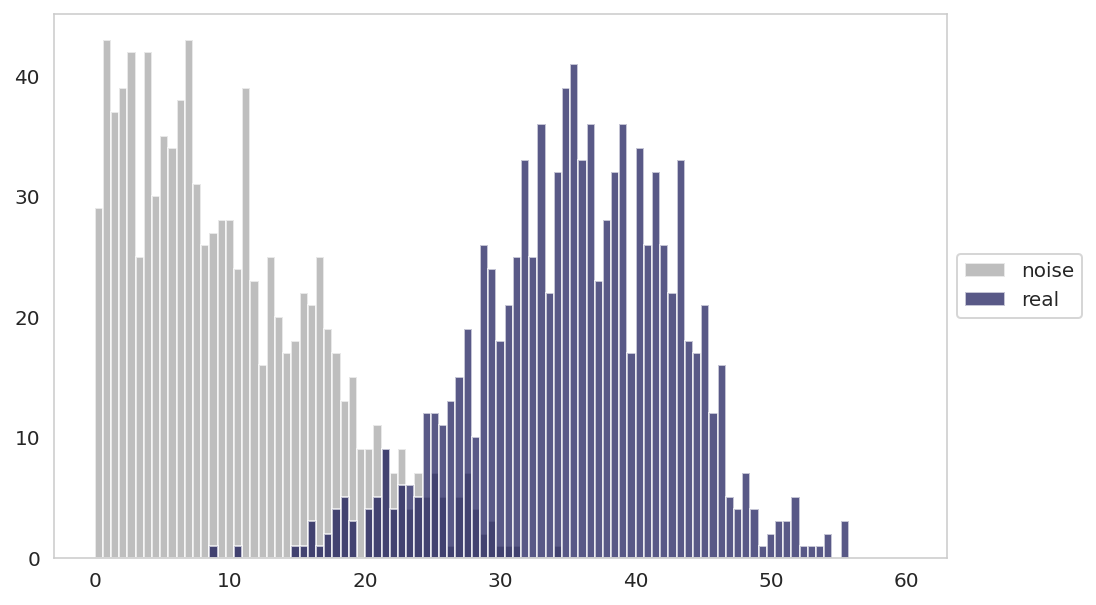

In [14]:
# log permut DBM/OVS
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,60,100)
plt.hist(noise_dbmovs_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(real_dbmovs_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4e_stats_OSR_OXPHOS_log_DBMOVS.svg', transparent=True)
#fig.savefig('../plots/fig4e_stats_OSR_OXPHOS_log_DBMOVS.png',dpi=300, transparent=True)


In [15]:
# sampling

#DBM/OVS

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['exp_conc']


alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['exp_conc']    

from numpy.random import seed
from numpy.random import randint

noise_dbmovs_val = []
real_dbmovs_val = []

for i in range(1, 1000):
    
    tmpc = get_samples(alltogether, 100, 2)
        
    noise_median1 = np.median(tmpc[0])
    noise_median2 = np.median(tmpc[1])

    noise_lq1 = np.percentile(tmpc[0], 25)  
    noise_uq1 = np.percentile(tmpc[0], 75)  

    noise_lq2 = np.percentile(tmpc[1], 25)  
    noise_uq2 = np.percentile(tmpc[1], 75)  

    noise_dbm = np.abs(noise_median1-noise_median2)
    noise_ovs = np.max([noise_uq1,noise_uq2]) - np.min([noise_lq1,noise_lq2])

    noise_dbmovs = 100*(noise_dbm/noise_ovs)

    
#    
    noise_dbmovs_val.append(noise_dbmovs)
    
##

    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    real_median1 = np.median(sample1)
    real_median2 = np.median(sample2)

    real_lq1 = np.percentile(sample1, 25)  
    real_uq1 = np.percentile(sample1, 75)  

    real_lq2 = np.percentile(sample2, 25)  
    real_uq2 = np.percentile(sample2, 75)  

    real_dbm = np.abs(real_median1-real_median2)
    real_ovs = np.max([real_uq1,real_uq2]) - np.min([real_lq1,real_lq2])

    real_dbmovs = 100*(real_dbm/real_ovs)

#
    real_dbmovs_val.append(real_dbmovs)
    

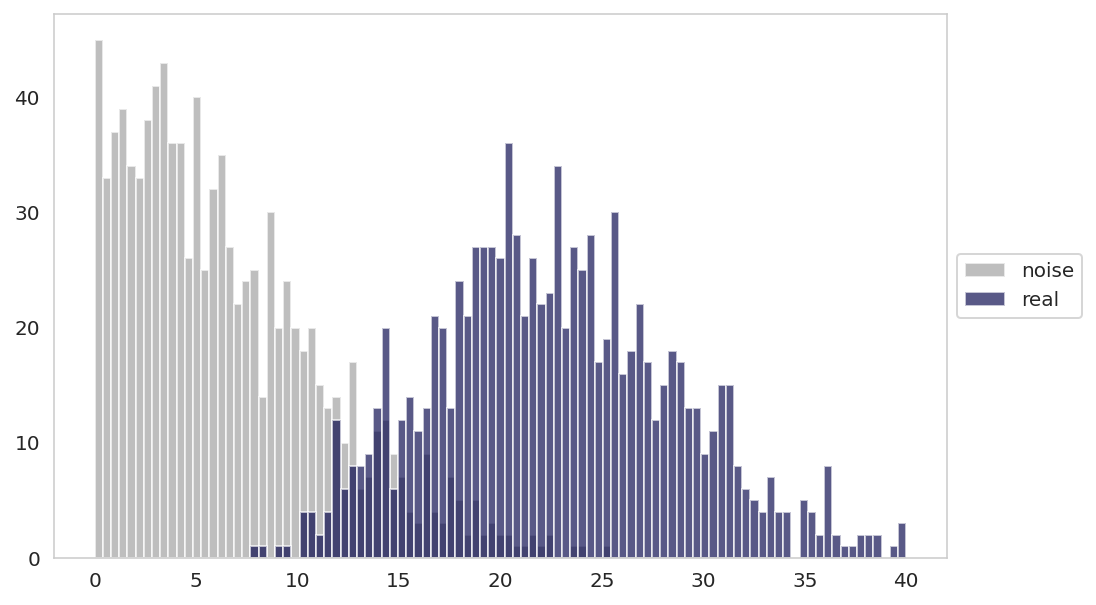

In [16]:
# exp permut DBM/OVS
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,40,100)
plt.hist(noise_dbmovs_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(real_dbmovs_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3B_stats_OSR_OXPHOS_exp_DBMOVS.svg', transparent=True)
#fig.savefig('../plots/S3B_stats_OSR_OXPHOS_exp_DBMOVS.png',dpi=300, transparent=True)



Wilcoxon-Mann-Whitney U test

In [17]:
# sampling

#WMW U

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = mannwhitneyu(tmpc[0], tmpc[1],alternative='two-sided')
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = mannwhitneyu(sample1, sample2,alternative='two-sided')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

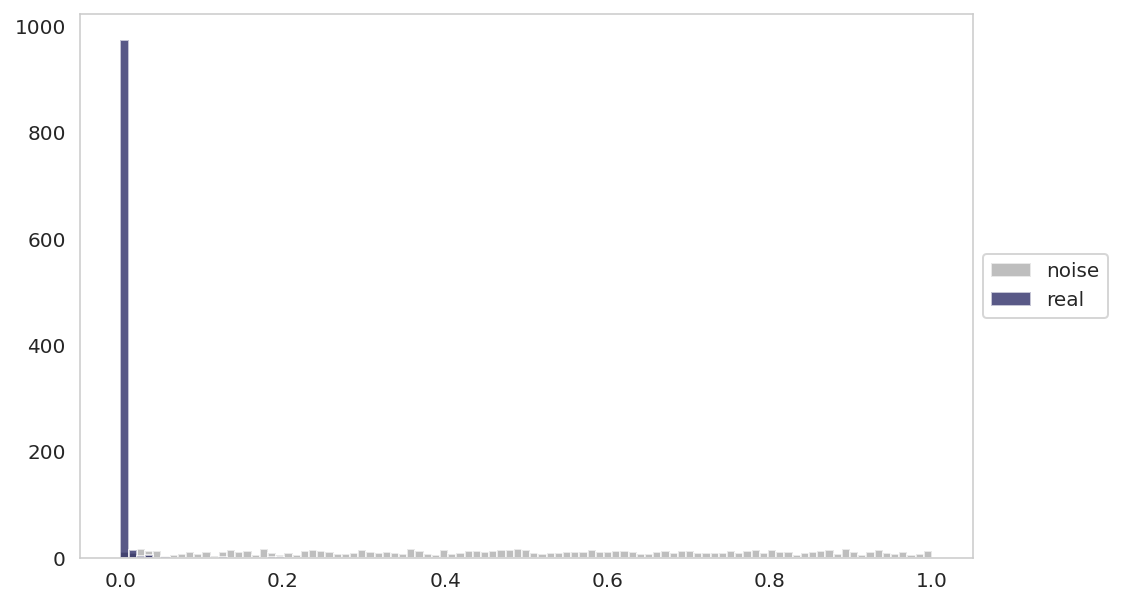

In [18]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()


#fig.savefig('../plots/fig4h_stats_OSR_OXPHOS_log_MWU2side_pval.svg', transparent=True)
#fig.savefig('../plots/fig4h_stats_OSR_OXPHOS_log_MWU2side_pval.png',dpi=300, transparent=True)



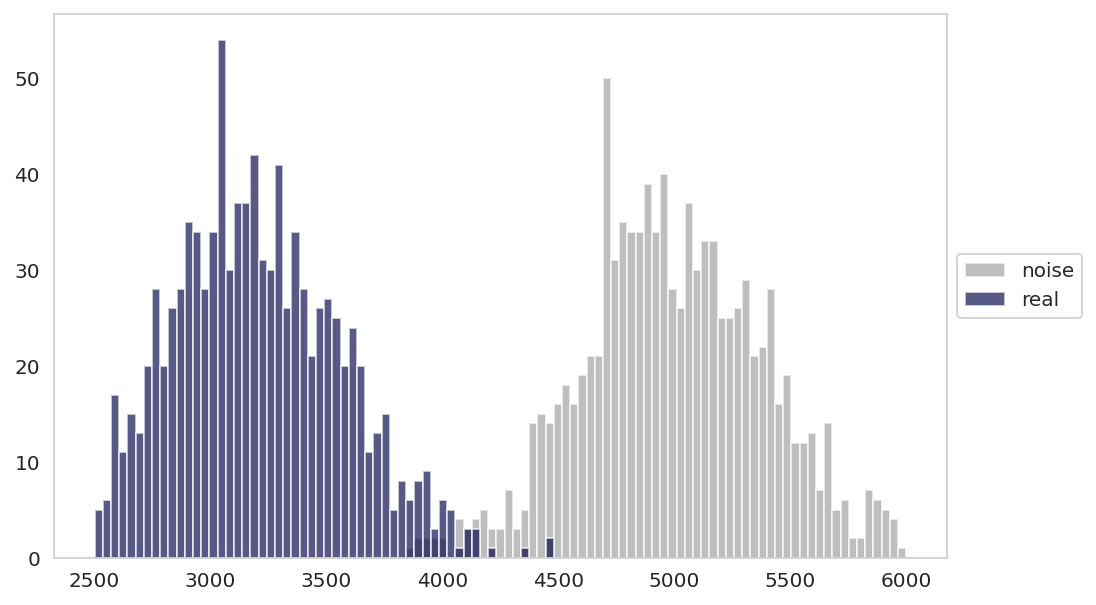

In [19]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(2500,6000,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4h_stats_OSR_OXPHOS_log_MWU2side_val.svg', transparent=True)
#fig.savefig('../plots/fig4h_stats_OSR_OXPHOS_log_MWU2side_val.png',dpi=300, transparent=True)


In [20]:
# sampling

#WMW U

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['exp_conc']    


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = mannwhitneyu(tmpc[0], tmpc[1],alternative='two-sided')
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = mannwhitneyu(sample1, sample2,alternative='two-sided')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

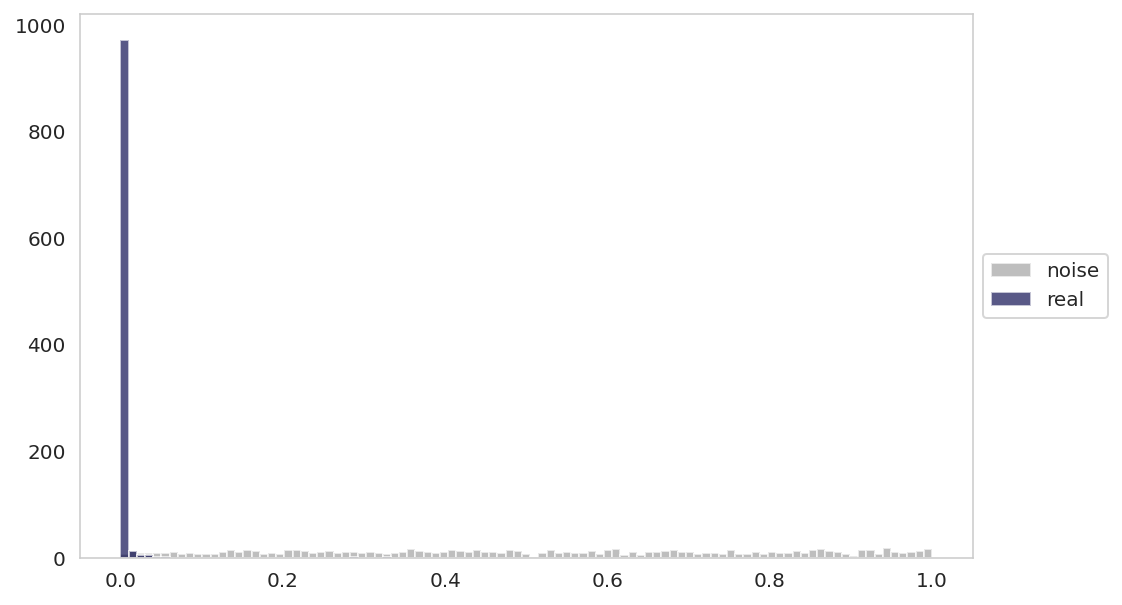

In [21]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3E_stats_OSR_OXPHOS_exp_MWU2side_pval.svg', transparent=True)
#fig.savefig('../plots/S3E_stats_OSR_OXPHOS_exp_MWU2side_pval.png',dpi=300, transparent=True)


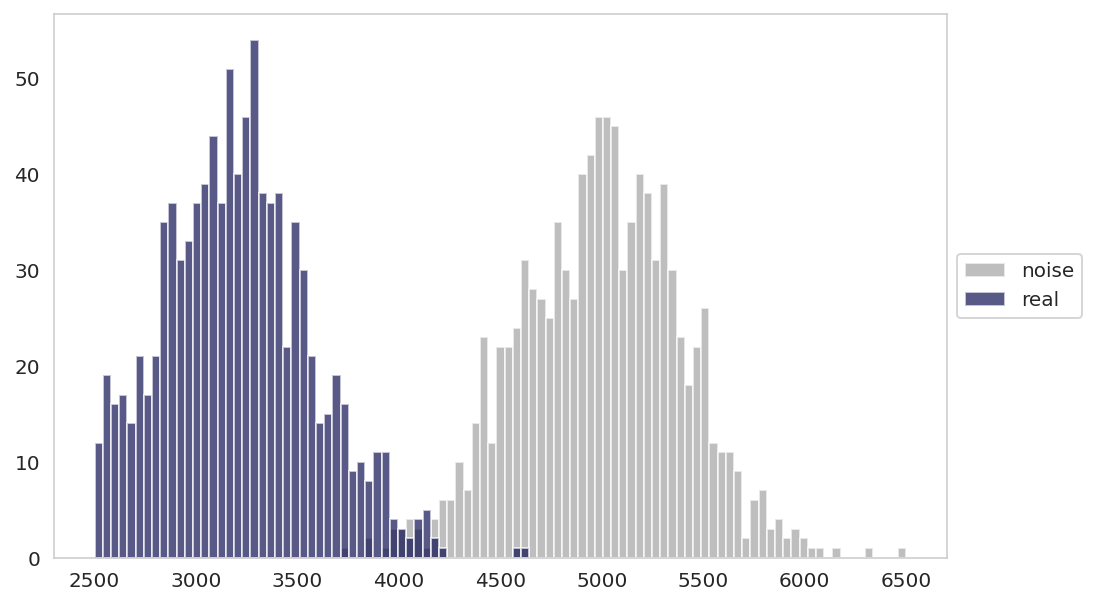

In [22]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(2500,6500,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3E_stats_OSR_OXPHOS_exp_MWU2side_val.svg', transparent=True)
#fig.savefig('../plots/S3E_stats_OSR_OXPHOS_exp_MWU2side_val.png',dpi=300, transparent=True)


KS

In [23]:
# sampling

#KS

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = ks_2samp(tmpc[0], tmpc[1])
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = ks_2samp(sample1, sample2)
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

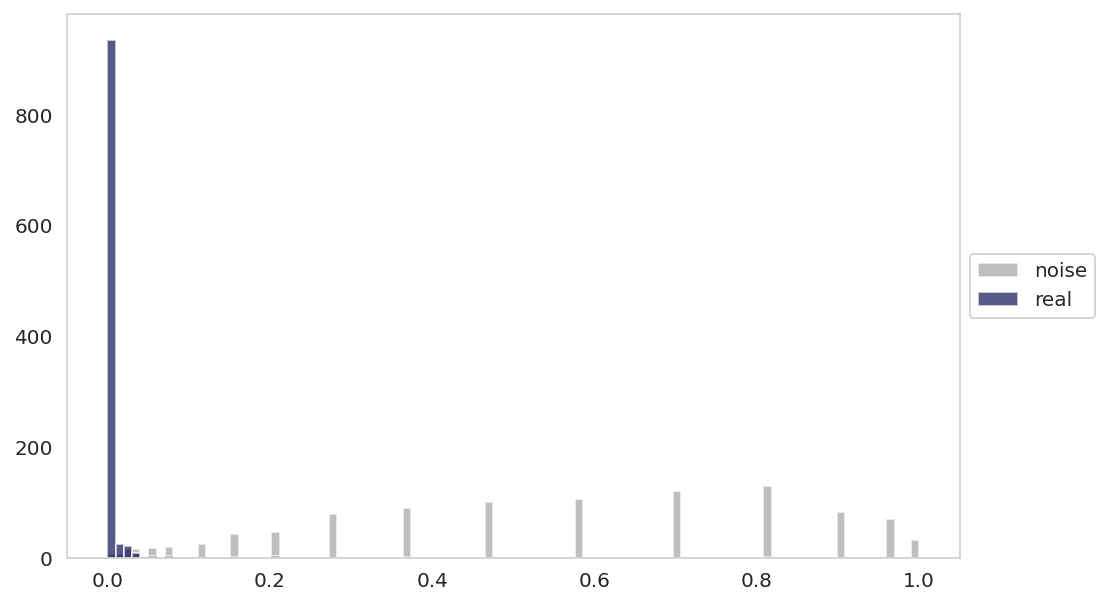

In [24]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4k_stats_OSR_OXPHOS_log_KS2sample_pval.svg', transparent=True)
#fig.savefig('../plots/fig4k_stats_OSR_OXPHOS_log_KS2sample_pval.png',dpi=300, transparent=True)


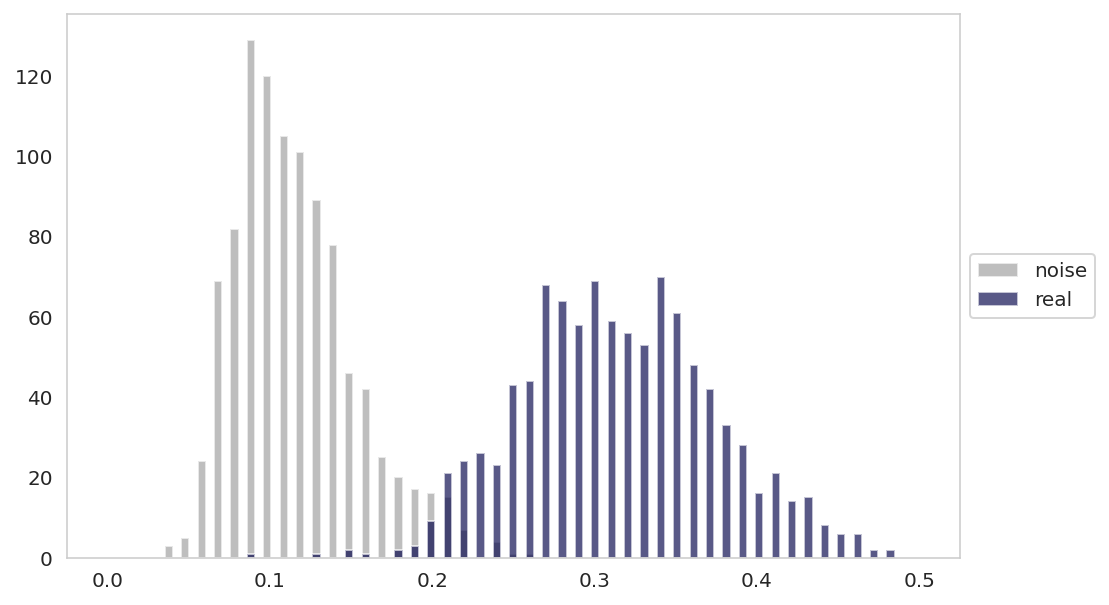

In [25]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,0.5,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4k_stats_OSR_OXPHOS_log_KS2sample_val.svg', transparent=True)
#fig.savefig('../plots/fig4k_stats_OSR_OXPHOS_log_KS2sample_val.png', dpi=300, transparent=True)


In [26]:
# sampling

#KS

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['exp_conc']    


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = ks_2samp(tmpc[0], tmpc[1])
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = ks_2samp(sample1, sample2)
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

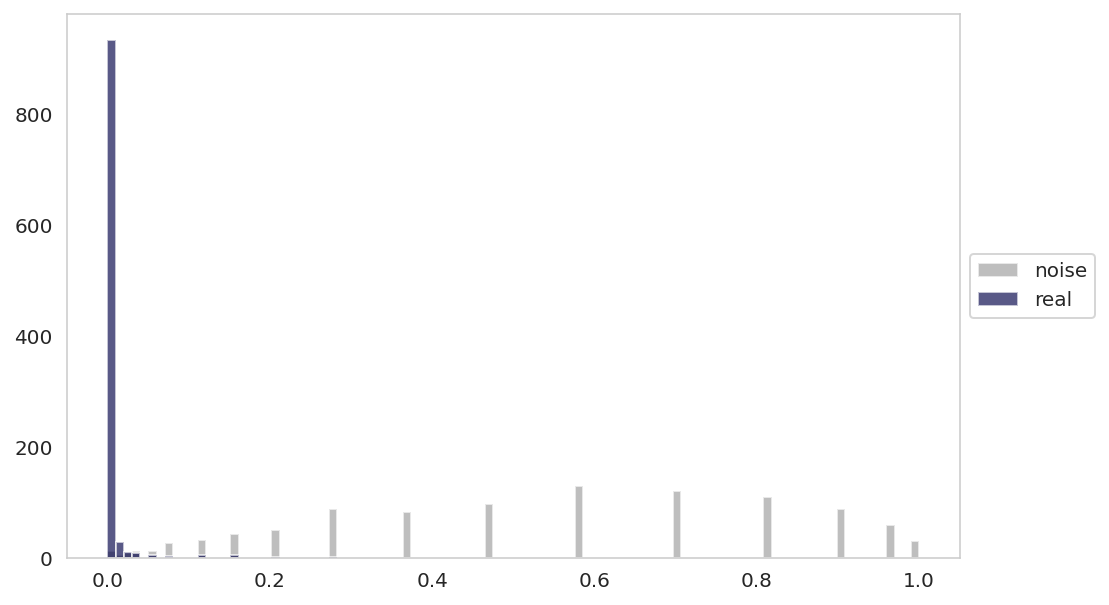

In [27]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3H_stats_OSR_OXPHOS_exp_KS2sample_pval.svg', transparent=True)
#fig.savefig('../plots/S3H_stats_OSR_OXPHOS_exp_KS2sample_pval.png',dpi=300,  transparent=True)


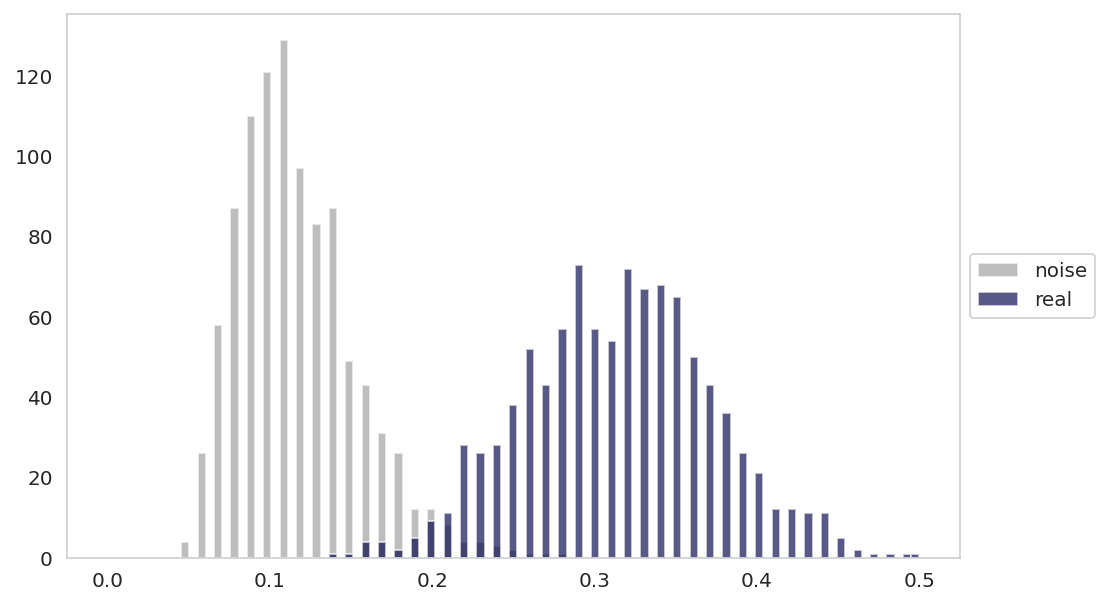

In [28]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,0.5,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3H_stats_OSR_OXPHOS_exp_KS2sample_val.svg', transparent=True)
#fig.savefig('../plots/S3H_stats_OSR_OXPHOS_exp_KS2sample_val.png',dpi=300,  transparent=True)


Brown-Forsythe (modified Levene) test for equality of variances

In [29]:
# sampling

#Brown-Forsythe (modified Levene)

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = levene(tmpc[0], tmpc[1], center='median') 
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = levene(sample1, sample2, center='median') 
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

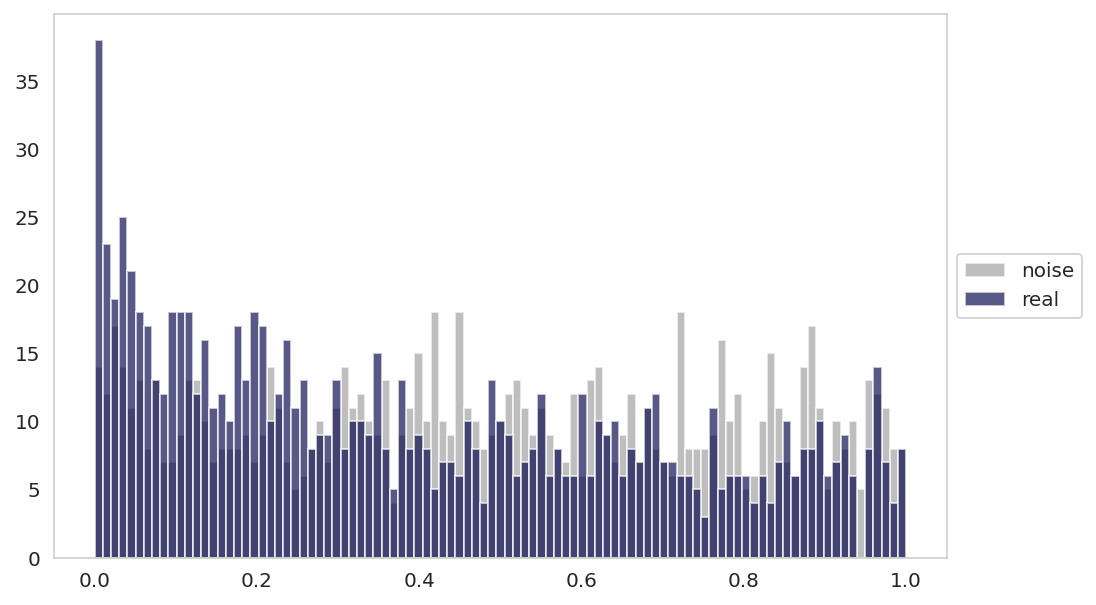

In [30]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4n_stats_OSR_OXPHOS_log_BFLev_pval.svg', transparent=True)
#fig.savefig('../plots/fig4n_stats_OSR_OXPHOS_log_BFLev_pval.png',  dpi=300, transparent=True)


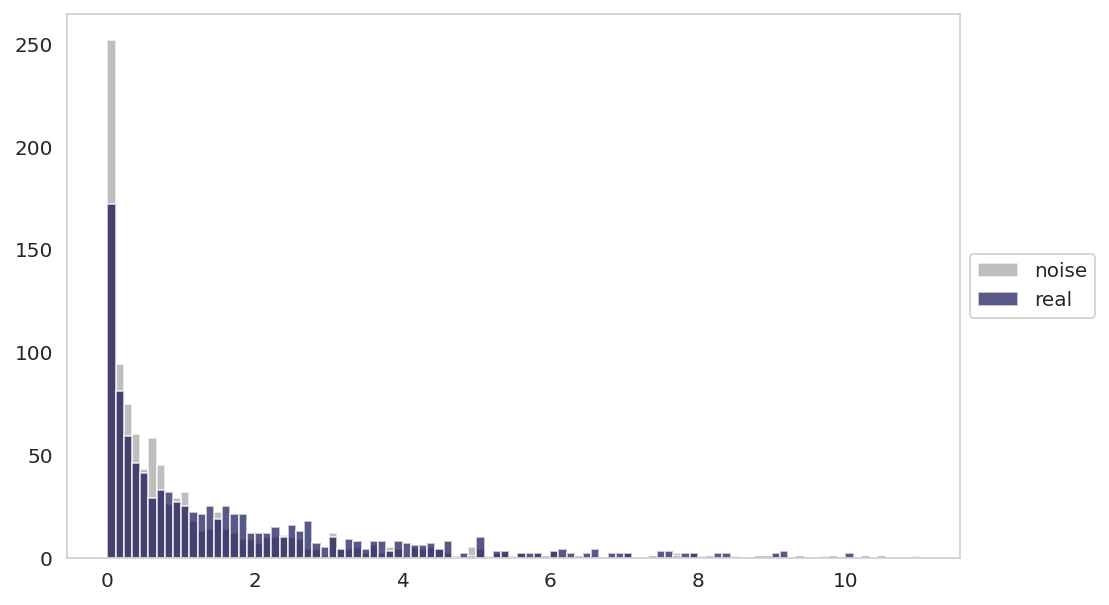

In [31]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4n_stats_OSR_OXPHOS_log_BFLev_val.svg', transparent=True)
#fig.savefig('../plots/fig4n_stats_OSR_OXPHOS_log_BFLev_val.png', dpi=300,transparent=True)


In [32]:
# sampling

#Brown-Forsythe (modified Levene)

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['exp_conc']    


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = levene(tmpc[0], tmpc[1], center='median') 
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = levene(sample1, sample2, center='median') 
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

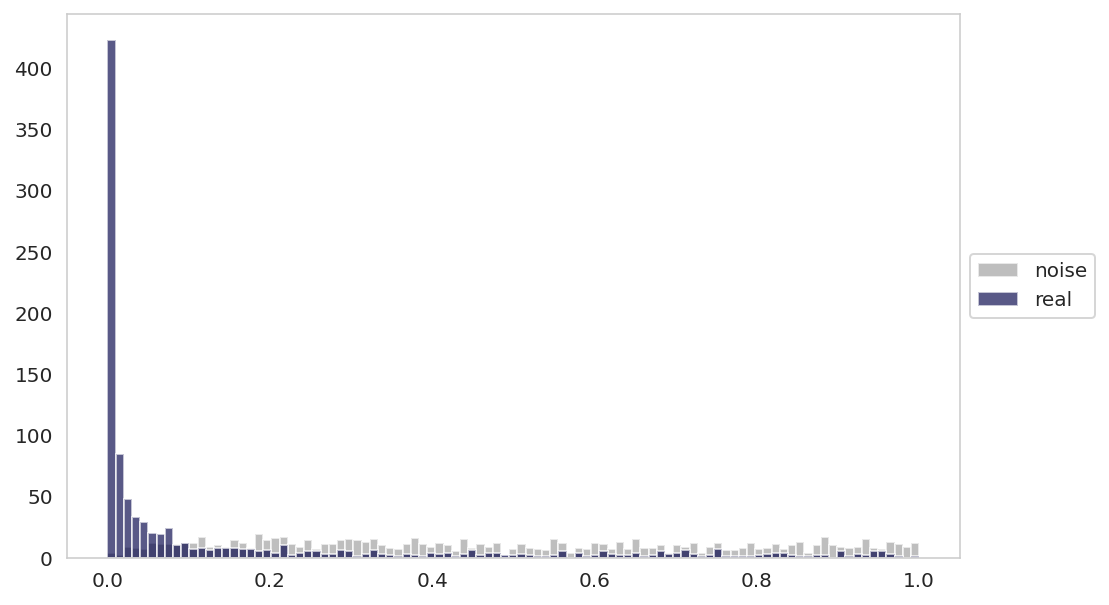

In [33]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3K_stats_OSR_OXPHOS_exp_BFLev_pval.svg', transparent=True)
#fig.savefig('../plots/S3K_stats_OSR_OXPHOS_exp_BFLev_pval.png',dpi=300, transparent=True)


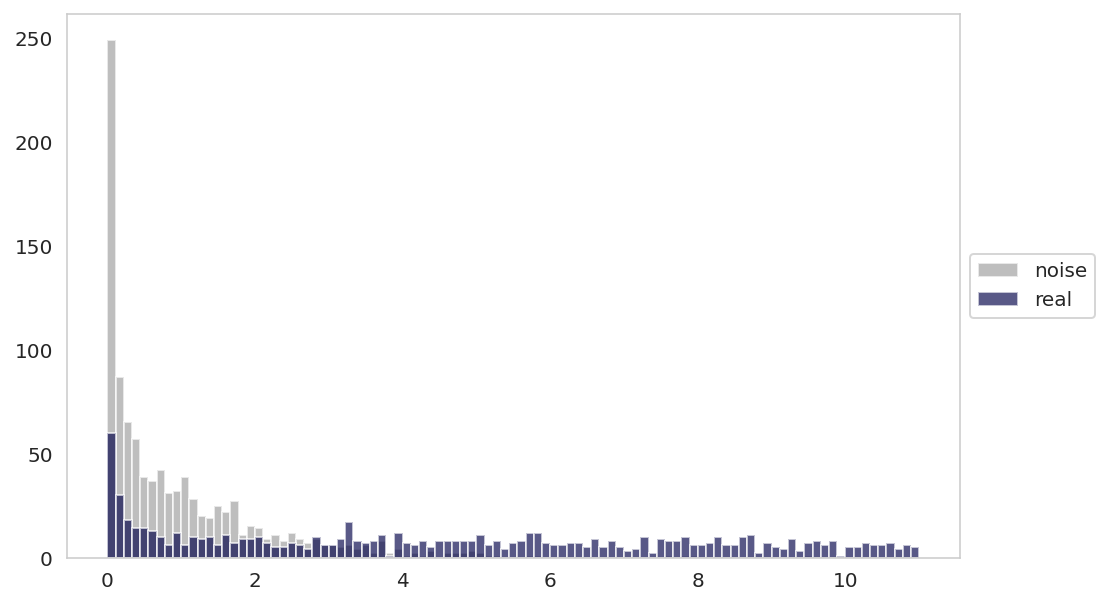

In [34]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3K_stats_OSR_OXPHOS_exp_BFLev_val.svg', transparent=True)
#fig.savefig('../plots/S3K_stats_OSR_OXPHOS_exp_BFLev_val.png', dpi=300, transparent=True)


Fligner-Killeen test for equality of variances (non-parametric, median-centered)

In [35]:
# sampling

# Fligner-Killeen test for equality of variances (non-parametric, median-centered)

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = fligner(tmpc[0], tmpc[1],center='median')  
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = fligner(sample1, sample2,center='median')  
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

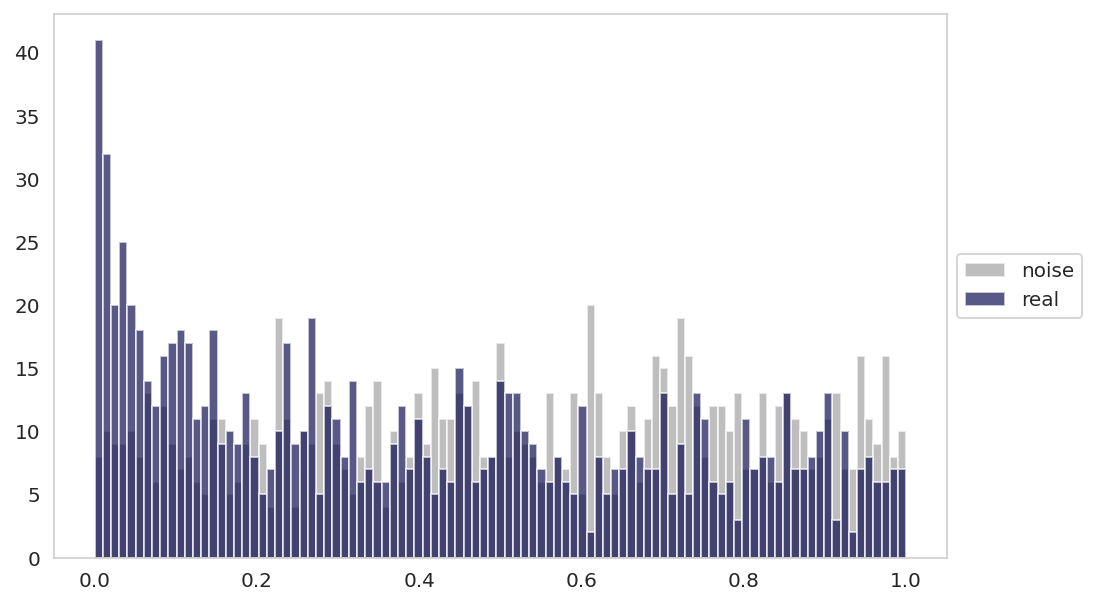

In [36]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4q_stats_OSR_OXPHOS_log_fligner_pval.svg', transparent=True)
#fig.savefig('../plots/fig4q_stats_OSR_OXPHOS_log_fligner_pval.png',dpi=300, transparent=True)


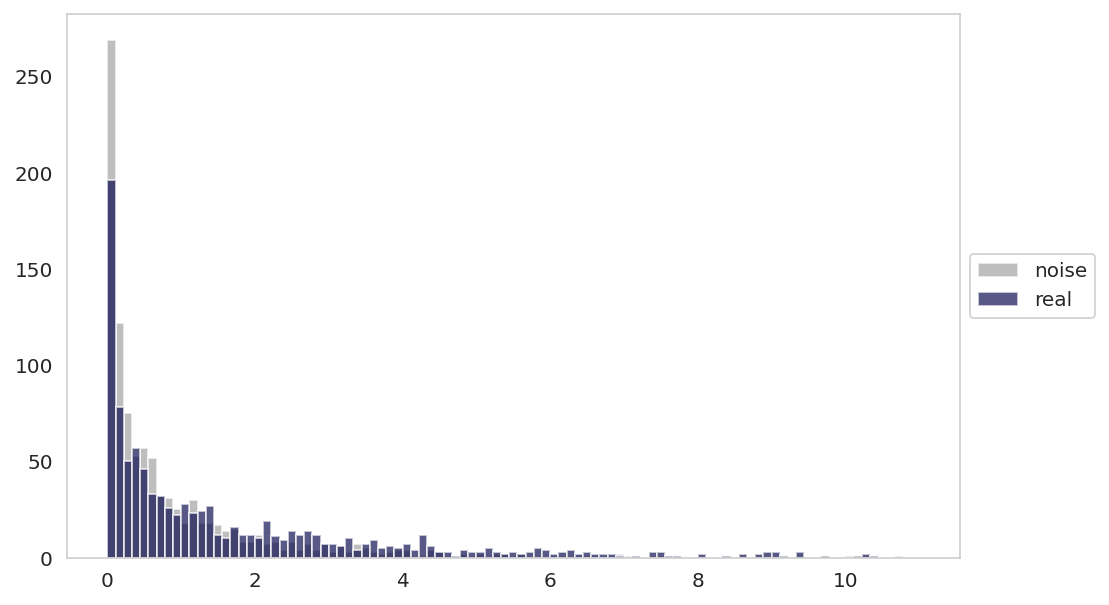

In [37]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4q_stats_OSR_OXPHOS_log_fligner_val.svg', transparent=True)
#fig.savefig('../plots/fig4q_stats_OSR_OXPHOS_log_fligner_val.png',dpi=300, transparent=True)


In [38]:
# sampling

# Fligner-Killeen test for equality of variances (non-parametric, median-centered)

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative phosphorylation')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&(fun_df['location']=='neurons')]['exp_conc']    

from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = fligner(tmpc[0], tmpc[1],center='median')  
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = fligner(sample1, sample2,center='median')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

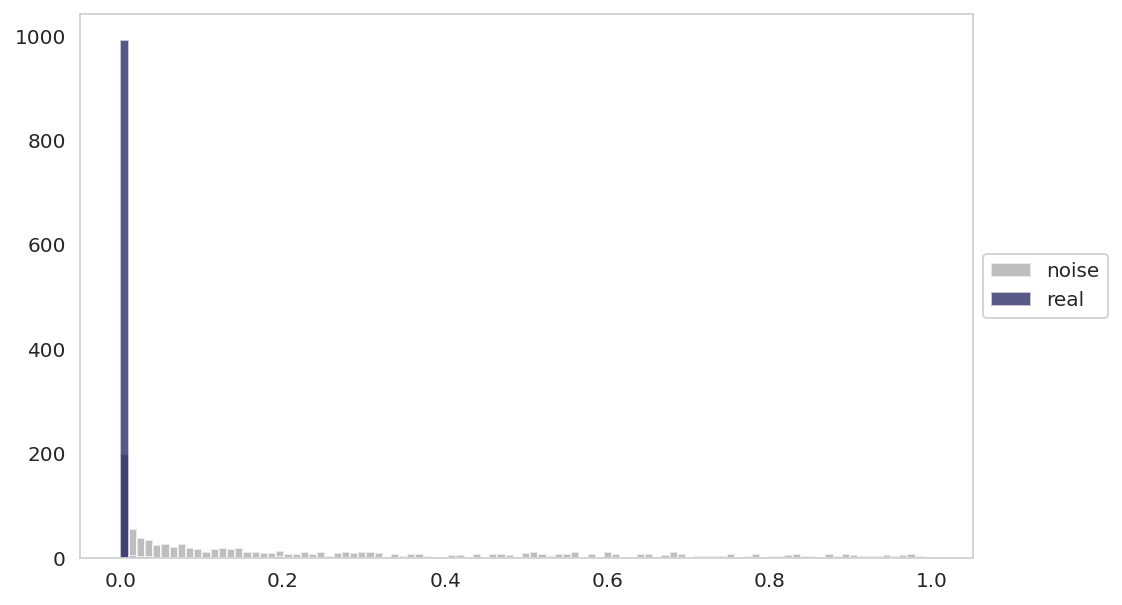

In [39]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3N_stats_OSR_OXPHOS_exp_fligner_pval.svg', transparent=True)
#fig.savefig('../plots/S3N_stats_OSR_OXPHOS_exp_fligner_pval.png',dpi=300, transparent=True)


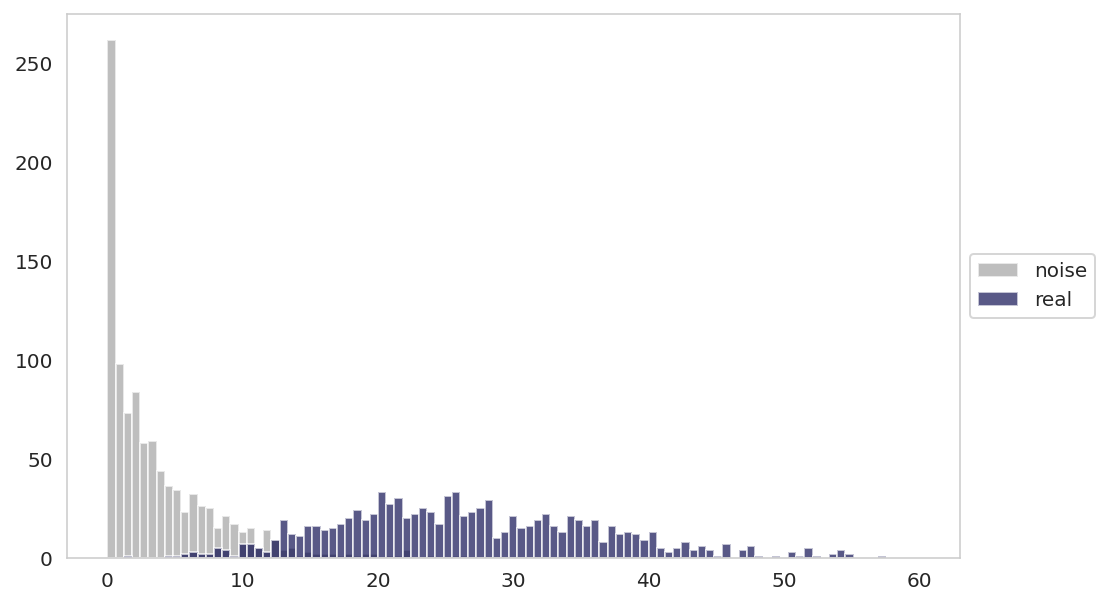

In [40]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,60,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3N_stats_OSR_OXPHOS_exp_fligner_val.svg', transparent=True)
#fig.savefig('../plots/S3N_stats_OSR_OXPHOS_exp_fligner_val.png',dpi=300, transparent=True)


##### OSR vs DNA repair

DBM/OVS

In [41]:
# sampling

#DBM/OVS

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

from numpy.random import seed
from numpy.random import randint

noise_dbmovs_val = []
real_dbmovs_val = []

for i in range(1, 1000):
    
    tmpc = get_samples(alltogether, 100, 2)
        
    noise_median1 = np.median(tmpc[0])
    noise_median2 = np.median(tmpc[1])

    noise_lq1 = np.percentile(tmpc[0], 25)  
    noise_uq1 = np.percentile(tmpc[0], 75)  

    noise_lq2 = np.percentile(tmpc[1], 25)  
    noise_uq2 = np.percentile(tmpc[1], 75)  

    noise_dbm = np.abs(noise_median1-noise_median2)
    noise_ovs = np.max([noise_uq1,noise_uq2]) - np.min([noise_lq1,noise_lq2])

    noise_dbmovs = 100*(noise_dbm/noise_ovs)

    
#    
    noise_dbmovs_val.append(noise_dbmovs)
    
##

    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    real_median1 = np.median(sample1)
    real_median2 = np.median(sample2)

    real_lq1 = np.percentile(sample1, 25)  
    real_uq1 = np.percentile(sample1, 75)  

    real_lq2 = np.percentile(sample2, 25)  
    real_uq2 = np.percentile(sample2, 75)  

    real_dbm = np.abs(real_median1-real_median2)
    real_ovs = np.max([real_uq1,real_uq2]) - np.min([real_lq1,real_lq2])

    real_dbmovs = 100*(real_dbm/real_ovs)

#
    real_dbmovs_val.append(real_dbmovs)
    

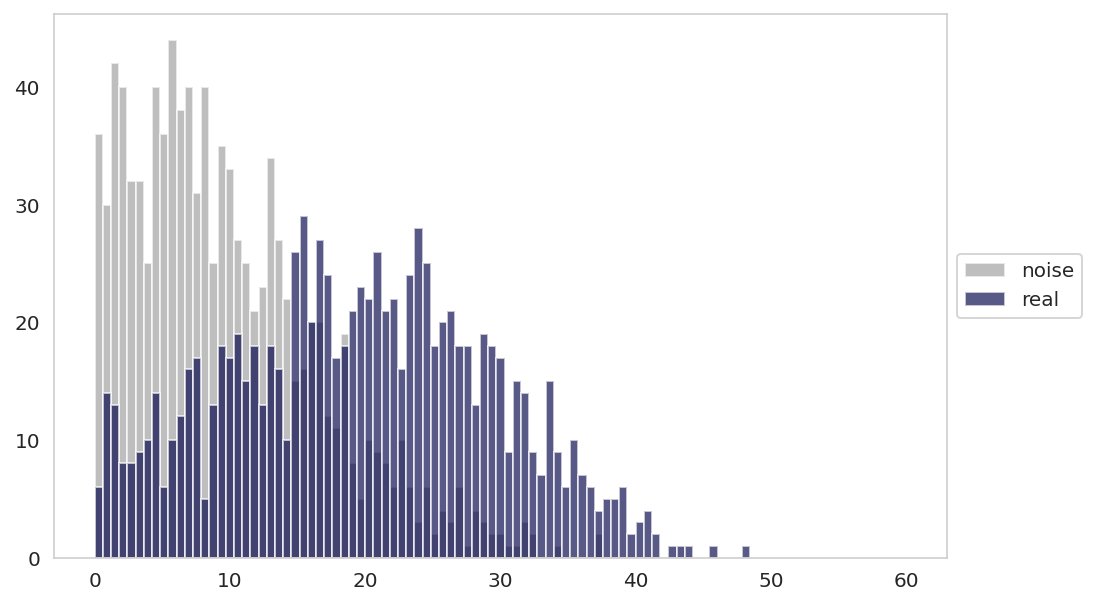

In [42]:
# log permut DBM/OVS
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,60,100)
plt.hist(noise_dbmovs_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(real_dbmovs_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4d_stats_OSR_DNArep_log_DBMOVS.svg', transparent=True)
#fig.savefig('../plots/fig4d_stats_OSR_DNArep_log_DBMOVS.png',dpi=300,  transparent=True)


In [43]:
# sampling

#DBM/OVS

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['exp_conc']

from numpy.random import seed
from numpy.random import randint

noise_dbmovs_val = []
real_dbmovs_val = []

for i in range(1, 1000):
    
    tmpc = get_samples(alltogether, 100, 2)
        
    noise_median1 = np.median(tmpc[0])
    noise_median2 = np.median(tmpc[1])

    noise_lq1 = np.percentile(tmpc[0], 25)  
    noise_uq1 = np.percentile(tmpc[0], 75)  

    noise_lq2 = np.percentile(tmpc[1], 25)  
    noise_uq2 = np.percentile(tmpc[1], 75)  

    noise_dbm = np.abs(noise_median1-noise_median2)
    noise_ovs = np.max([noise_uq1,noise_uq2]) - np.min([noise_lq1,noise_lq2])

    noise_dbmovs = 100*(noise_dbm/noise_ovs)

    
#    
    noise_dbmovs_val.append(noise_dbmovs)
    
##

    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    real_median1 = np.median(sample1)
    real_median2 = np.median(sample2)

    real_lq1 = np.percentile(sample1, 25)  
    real_uq1 = np.percentile(sample1, 75)  

    real_lq2 = np.percentile(sample2, 25)  
    real_uq2 = np.percentile(sample2, 75)  

    real_dbm = np.abs(real_median1-real_median2)
    real_ovs = np.max([real_uq1,real_uq2]) - np.min([real_lq1,real_lq2])

    real_dbmovs = 100*(real_dbm/real_ovs)

#
    real_dbmovs_val.append(real_dbmovs)
    

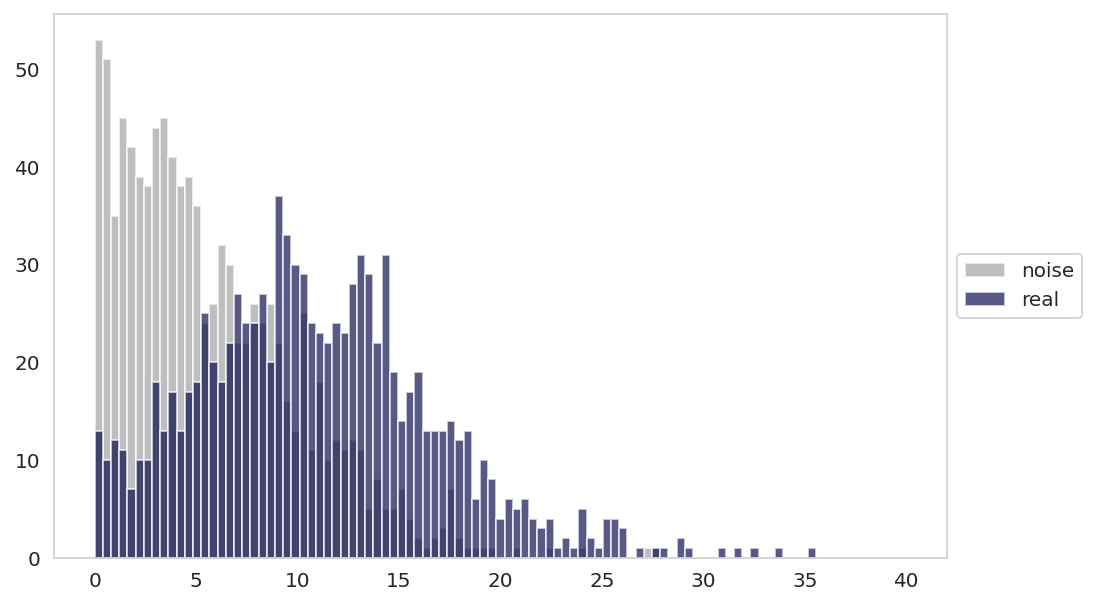

In [44]:
# exp permut DBM/OVS
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,40,100)
plt.hist(noise_dbmovs_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(real_dbmovs_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3A_stats_OSR_DNArep_exp_DBMOVS.svg', transparent=True)
#fig.savefig('../plots/S3A_stats_OSR_DNArep_exp_DBMOVS.png',dpi=300, transparent=True)



Wilcoxon-Mann-Whitney U test

In [45]:
# sampling

#WMW U

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = mannwhitneyu(tmpc[0], tmpc[1],alternative='two-sided')
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = mannwhitneyu(sample1, sample2,alternative='two-sided')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

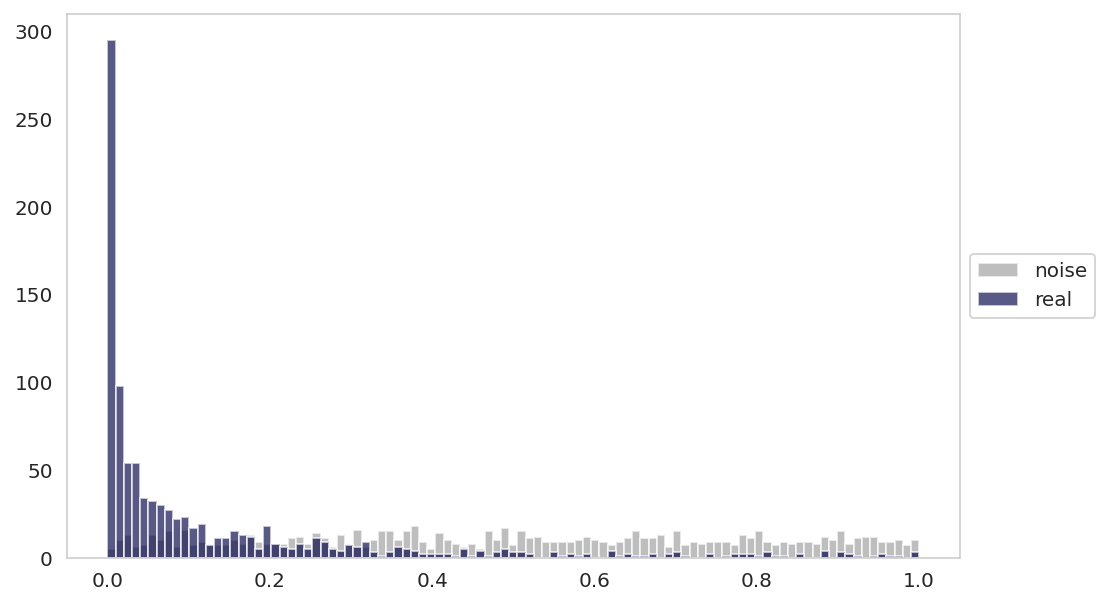

In [46]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4g_stats_OSR_DNArep_log_MWU2side_pval.svg', transparent=True)
#fig.savefig('../plots/fig4g_stats_OSR_DNArep_log_MWU2side_pval.png',dpi=300, transparent=True)


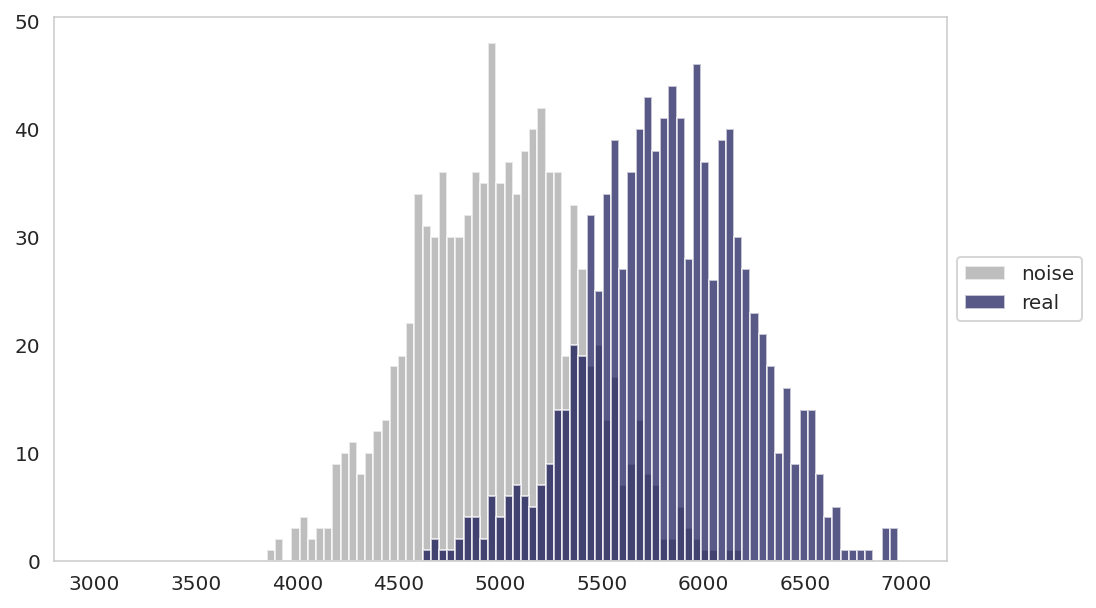

In [47]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(3000,7000,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4g_stats_OSR_DNArep_log_MWU2side_val.svg', transparent=True)
#fig.savefig('../plots/fig4g_stats_OSR_DNArep_log_MWU2side_val.png',dpi=300, transparent=True)


In [48]:
# sampling

#WMW U

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['exp_conc']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = mannwhitneyu(tmpc[0], tmpc[1],alternative='two-sided')
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = mannwhitneyu(sample1, sample2,alternative='two-sided')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

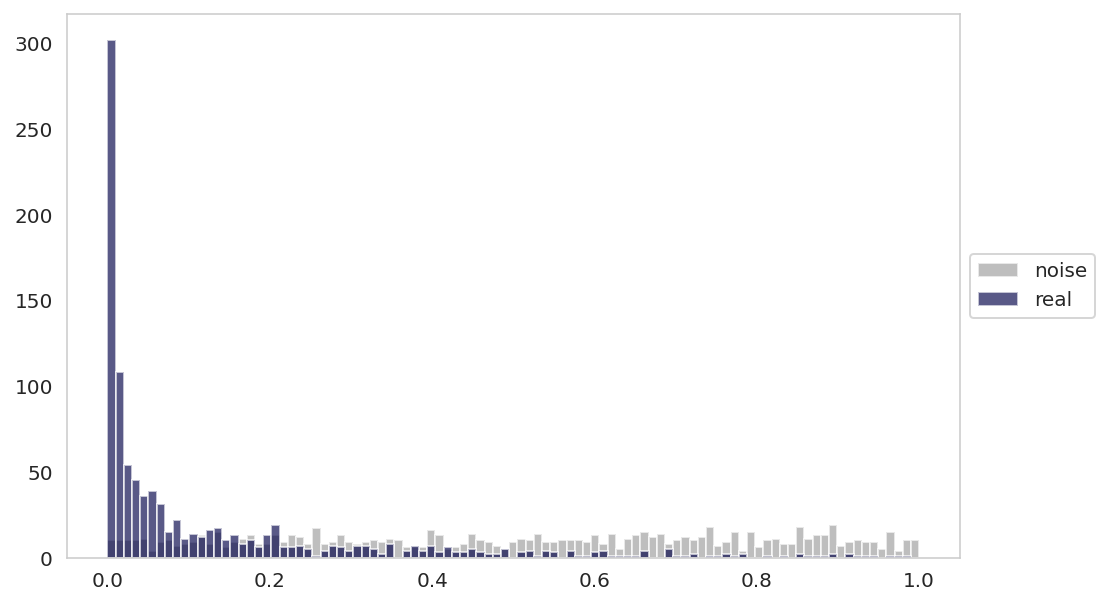

In [49]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3D_stats_OSR_DNArep_exp_MWU2side_pval.svg', transparent=True)
#fig.savefig('../plots/S3D_stats_OSR_DNArep_exp_MWU2side_pval.png',dpi=300, transparent=True)


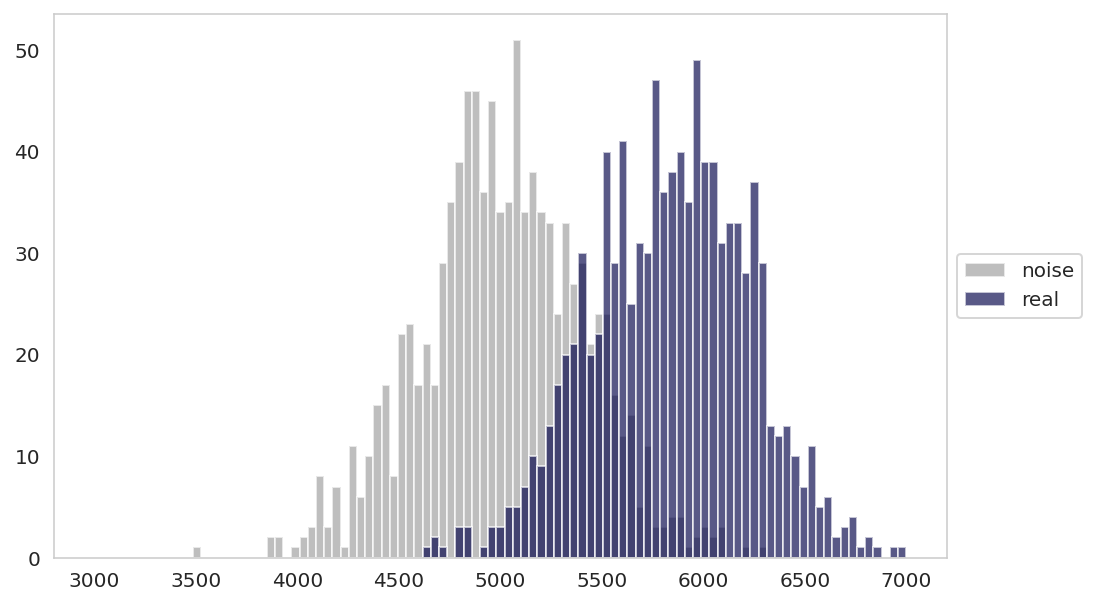

In [50]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(3000,7000,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3D_stats_OSR_DNArep_exp_MWU2side_val.svg', transparent=True)
#fig.savefig('../plots/S3D_stats_OSR_DNArep_exp_MWU2side_val.png',dpi=300, transparent=True)



KS

In [51]:
# sampling

#KS

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = ks_2samp(tmpc[0], tmpc[1])
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = ks_2samp(sample1, sample2)
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

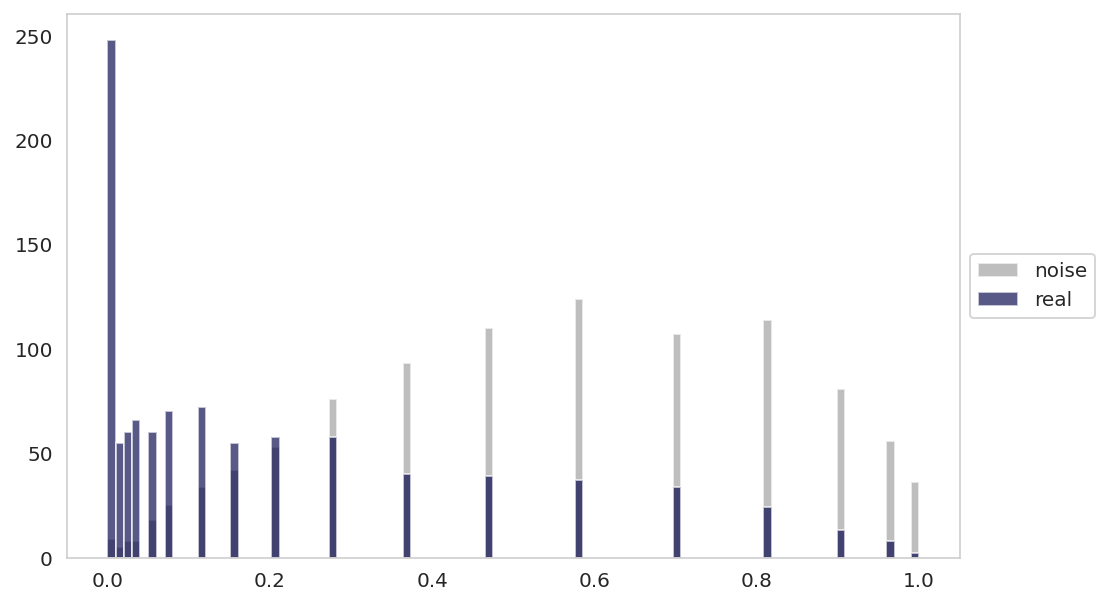

In [52]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4j_stats_OSR_DNArep_log_KS2sample_pval.svg', transparent=True)
#fig.savefig('../plots/fig4j_stats_OSR_DNArep_log_KS2sample_pval.png',dpi=300, transparent=True)




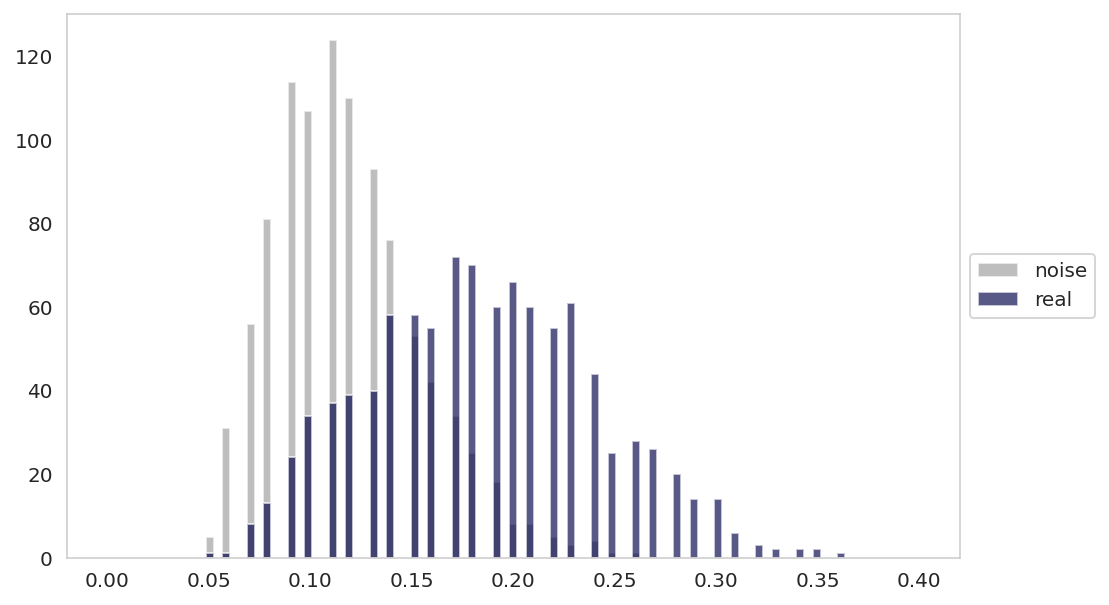

In [53]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,0.4,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4j_stats_OSR_DNArep_log_KS2sample_val.svg', transparent=True)
#fig.savefig('../plots/fig4j_stats_OSR_DNArep_log_KS2sample_val.png',dpi=300, transparent=True)


In [54]:
# sampling

#KS

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['exp_conc']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = ks_2samp(tmpc[0], tmpc[1])
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = ks_2samp(sample1, sample2)
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

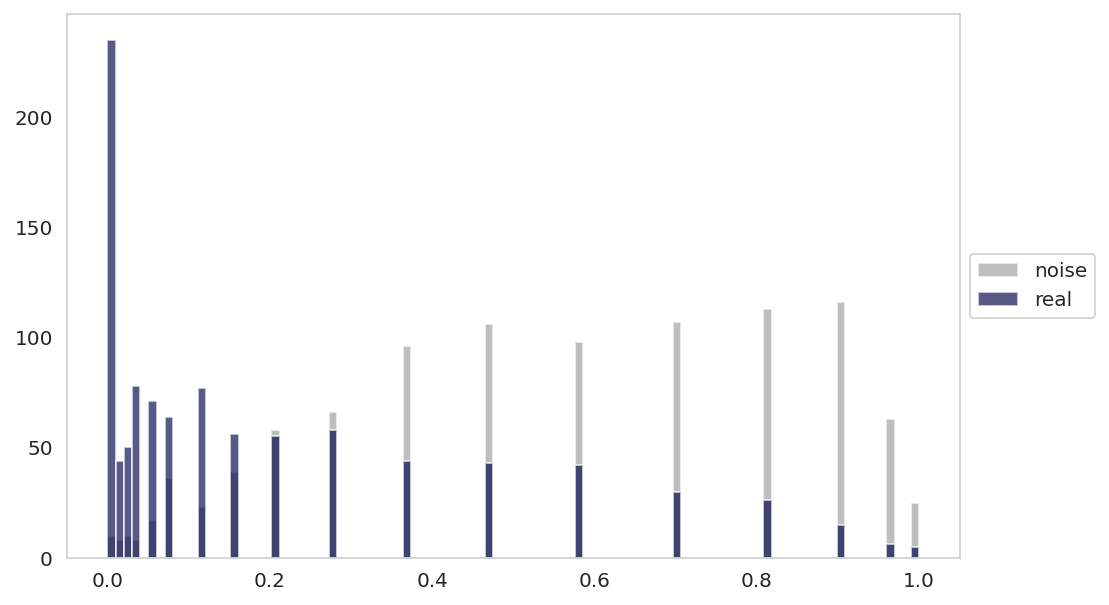

In [55]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3G_stats_OSR_DNArep_exp_KS2sample_pval.svg', transparent=True)
#fig.savefig('../plots/S3G_stats_OSR_DNArep_exp_KS2sample_pval.png',dpi=300, transparent=True)


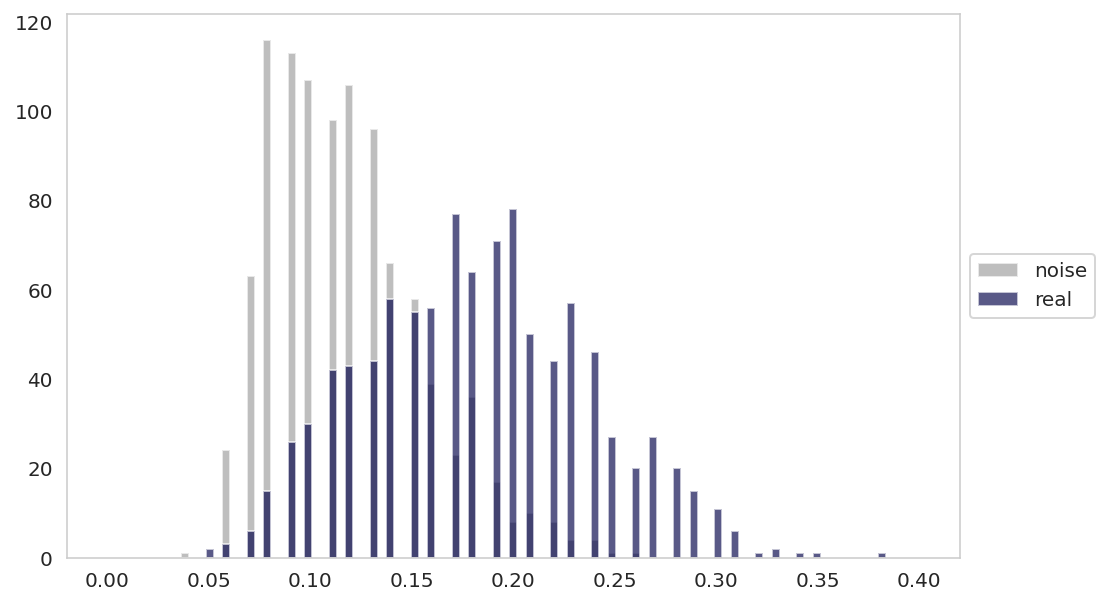

In [56]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,0.4,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3G_stats_OSR_DNArep_exp_KS2sample_val.svg', transparent=True)
#fig.savefig('../plots/S3G_stats_OSR_DNArep_exp_KS2sample_val.png',dpi=300, transparent=True)


Brown-Forsythe (modified Levene) test for equality of variances

In [57]:
# sampling

#Brown-Forsythe (modified Levene)

#log 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = levene(tmpc[0], tmpc[1], center='median') 
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = levene(sample1, sample2, center='median') 
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

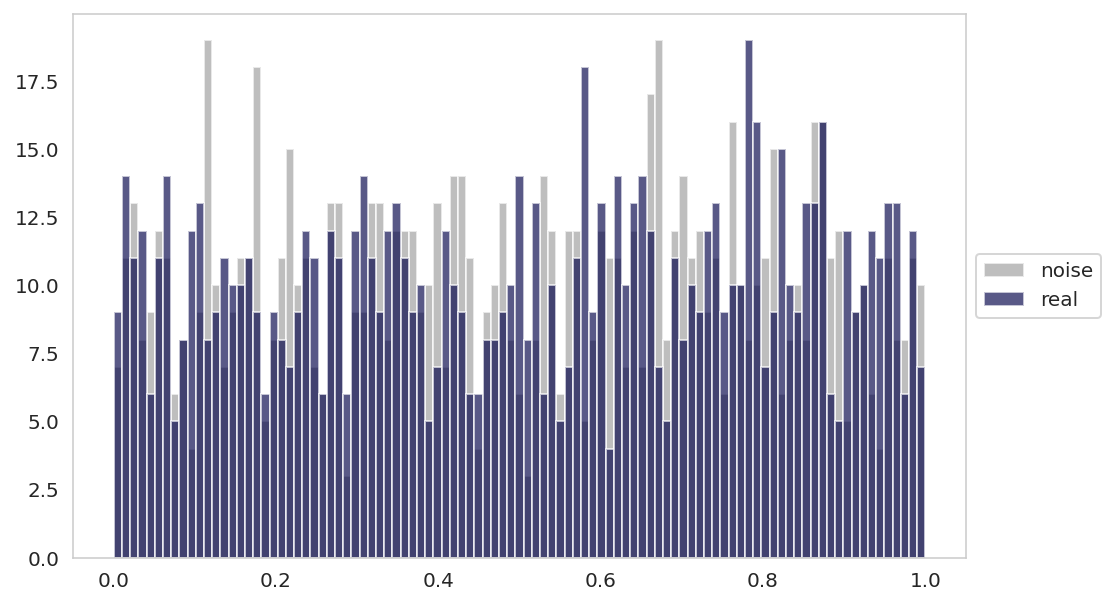

In [58]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4m_stats_OSR_DNArep_log_BFLev_pval.svg', transparent=True)
#fig.savefig('../plots/fig4m_stats_OSR_DNArep_log_BFLev_pval.png',dpi=300, transparent=True)


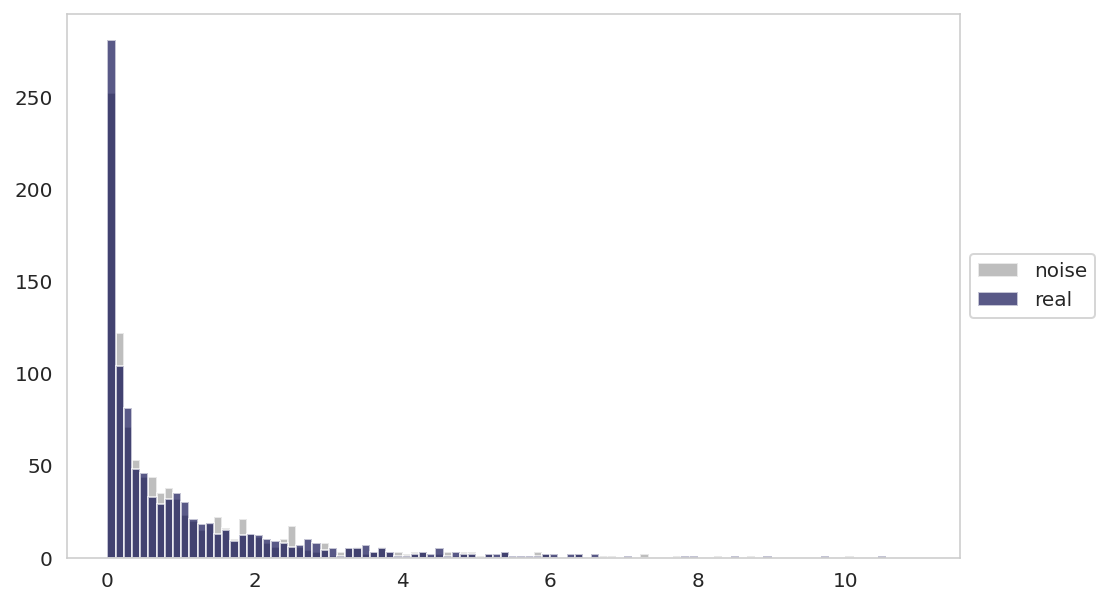

In [59]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4m_stats_OSR_DNArep_log_BFLev_val.svg', transparent=True)
#fig.savefig('../plots/fig4m_stats_OSR_DNArep_log_BFLev_val.png',dpi=300, transparent=True)


In [60]:
# sampling

#Brown-Forsythe (modified Levene)

#exp 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['exp_conc']

from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = levene(tmpc[0], tmpc[1], center='median') 
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = levene(sample1, sample2, center='median') 
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

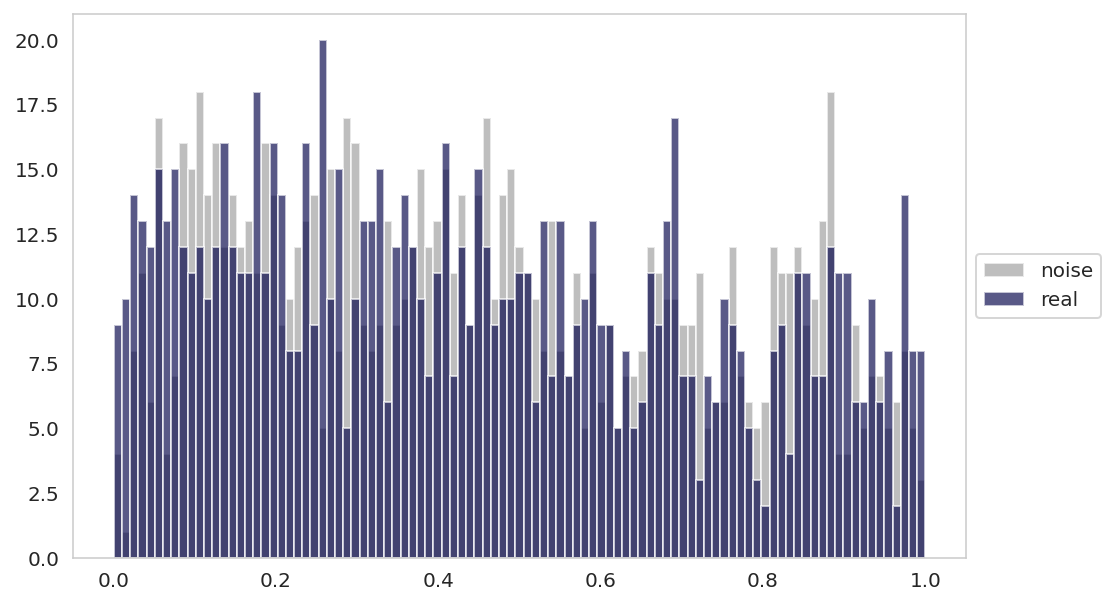

In [61]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3J_stats_OSR_DNArep_exp_BFLev_pval.svg', transparent=True)
#fig.savefig('../plots/S3J_stats_OSR_DNArep_exp_BFLev_pval.png',dpi=300, transparent=True)


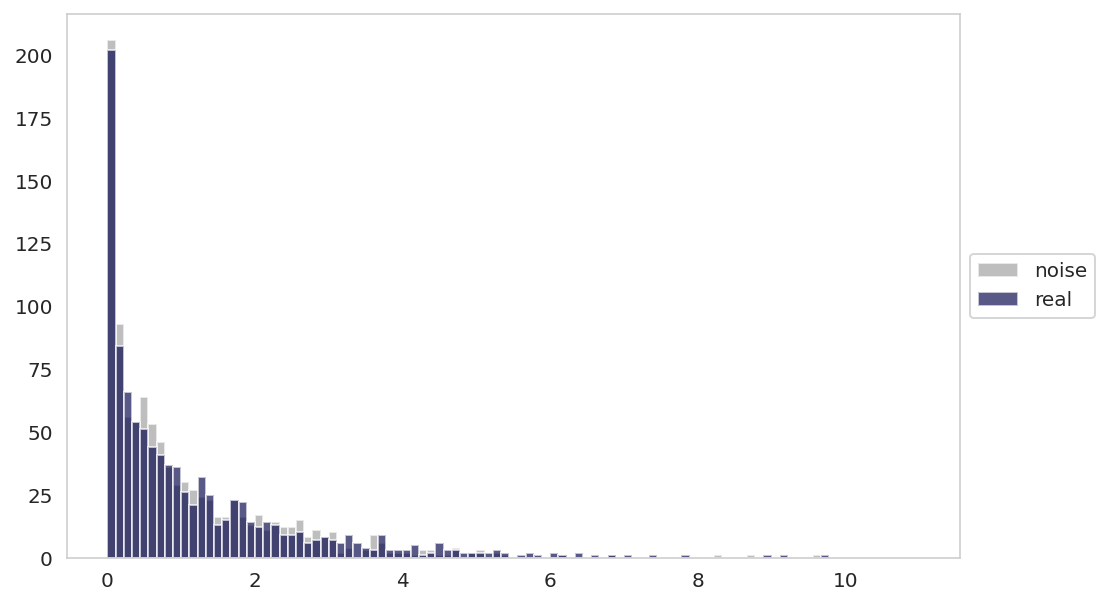

In [62]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3J_stats_OSR_DNArep_exp_BFLev_val.svg', transparent=True)
#fig.savefig('../plots/S3J_stats_OSR_DNArep_exp_BFLev_val.png',dpi=300, transparent=True)


Fligner-Killeen test for equality of variances (non-parametric, median-centered)

In [63]:
# sampling

# Fligner-Killeen test for equality of variances (non-parametric, median-centered)

#log 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['log_conc_uM_medNorm']

from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = fligner(tmpc[0], tmpc[1],center='median')  
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = fligner(sample1, sample2,center='median')  
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

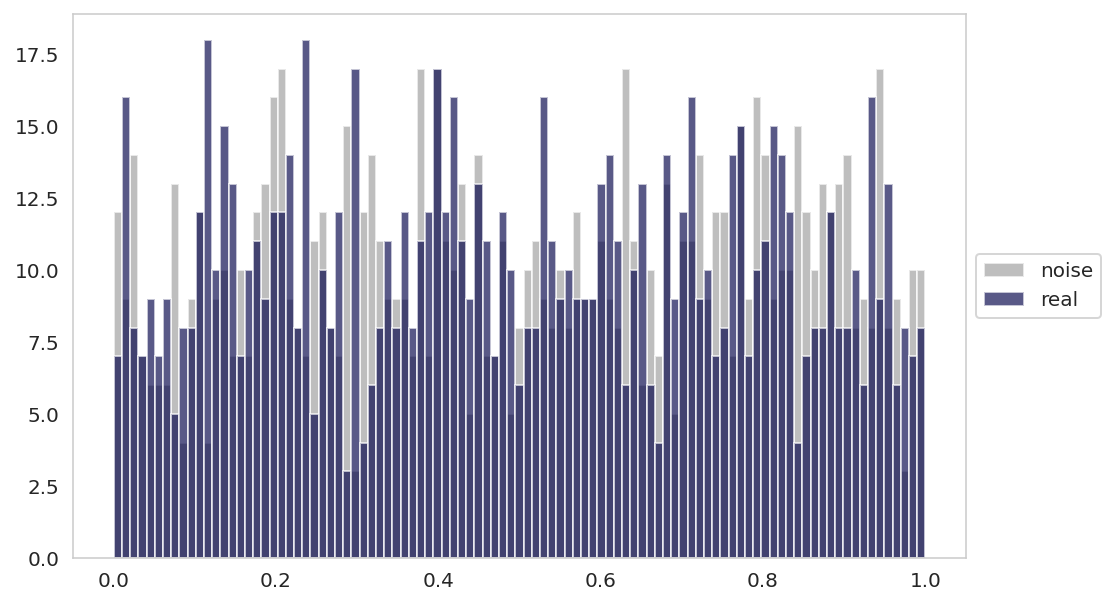

In [64]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4p_stats_OSR_DNArep_log_fligner_pval.svg', transparent=True)
#fig.savefig('../plots/fig4p_stats_OSR_DNArep_log_fligner_pval.png',dpi=300, transparent=True)


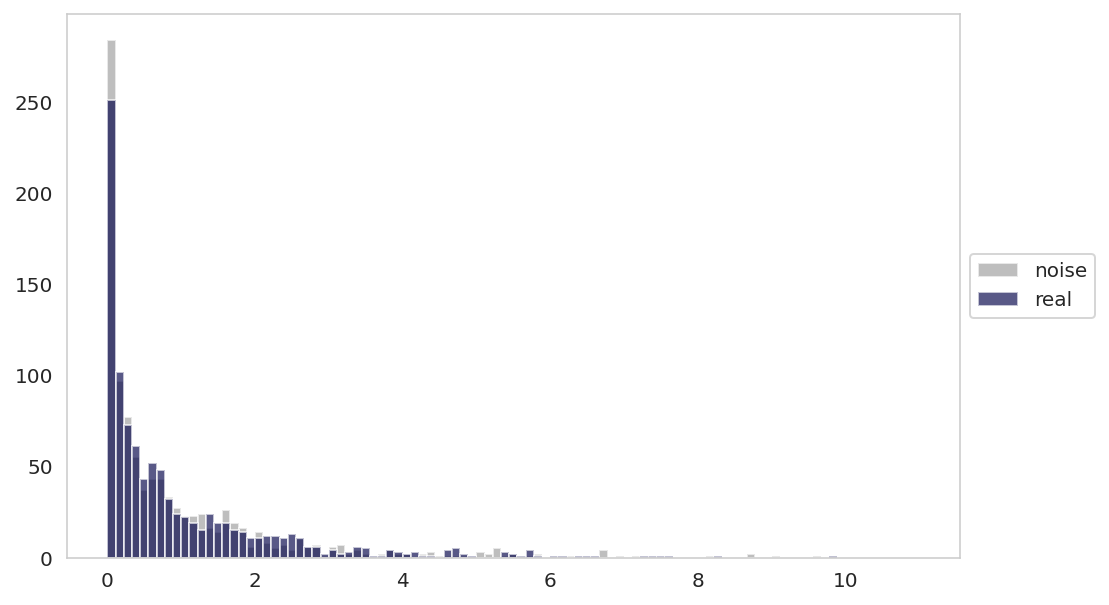

In [65]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4p_stats_OSR_DNArep_log_fligner_val.svg', transparent=True)
#fig.savefig('../plots/fig4p_stats_OSR_DNArep_log_fligner_val.png',dpi=300, transparent=True)



In [66]:
# sampling

# Fligner-Killeen test for equality of variances (non-parametric, median-centered)

#exp 

data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='DNA repair')&(fun_df['location']=='neurons')]['exp_conc']

alltogether = fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')]['exp_conc']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = fligner(tmpc[0], tmpc[1],center='median')  
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = fligner(sample1, sample2,center='median')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

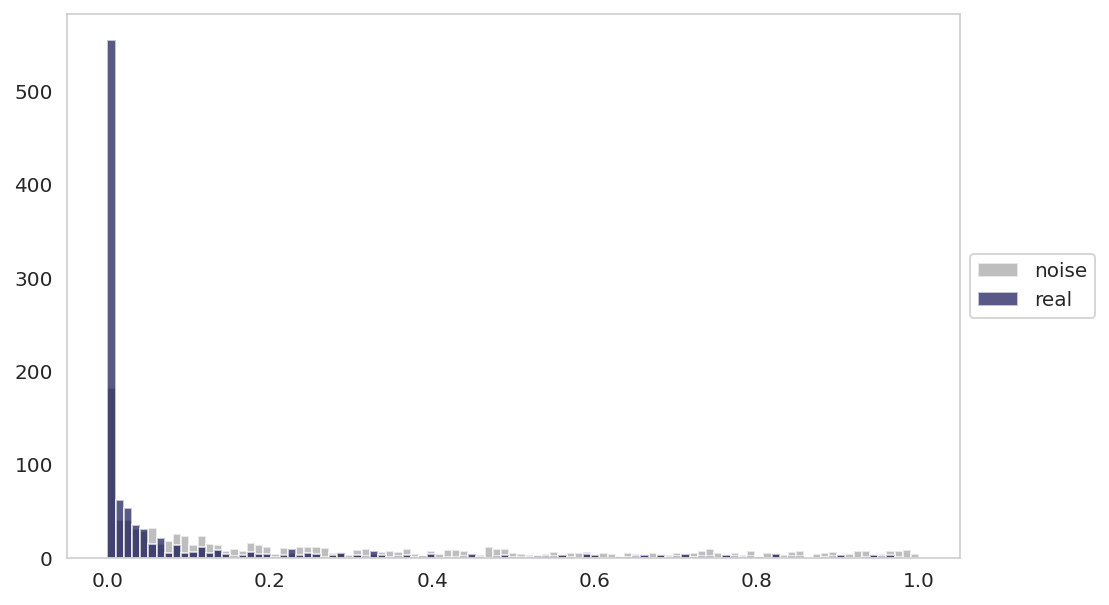

In [67]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3M_stats_OSR_DNArep_exp_fligner_pval.svg', transparent=True)
#fig.savefig('../plots/S3M_stats_OSR_DNArep_exp_fligner_pval.png',dpi=300, transparent=True)


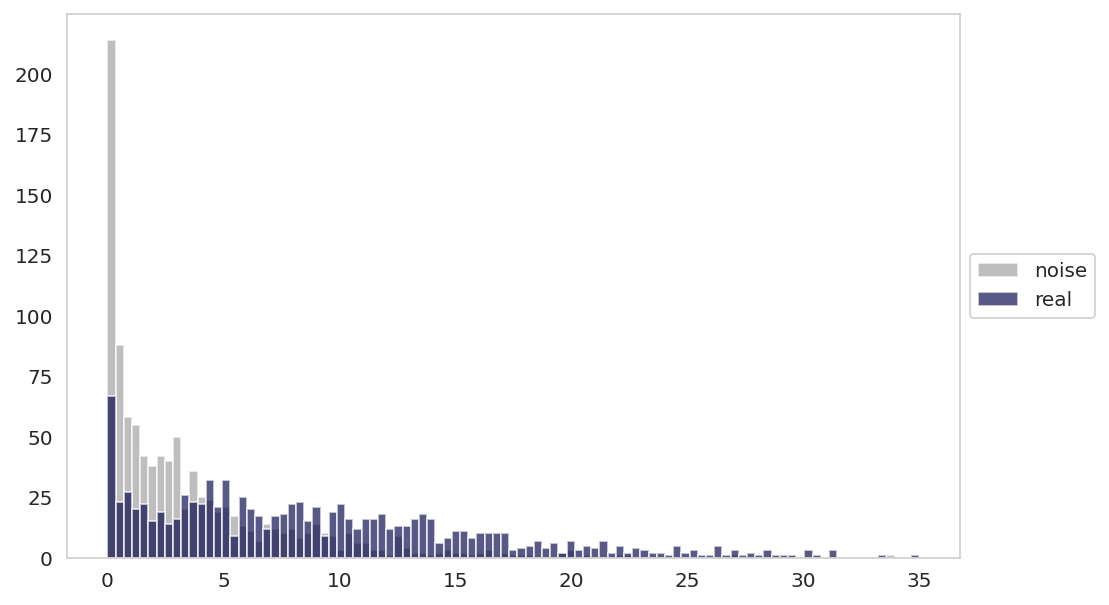

In [68]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,35,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3M_stats_OSR_DNArep_exp_fligner_val.svg', transparent=True)
#fig.savefig('../plots/S3M_stats_OSR_DNArep_exp_fligner_val.png',dpi=300, transparent=True)


##### Astrocytes vs neurons

DBM/OVS

In [69]:
# sampling

#DBM/OVS

#log 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

noise_dbmovs_val = []
real_dbmovs_val = []

for i in range(1, 1000):
    
    tmpc = get_samples(alltogether, 100, 2)
        
    noise_median1 = np.median(tmpc[0])
    noise_median2 = np.median(tmpc[1])

    noise_lq1 = np.percentile(tmpc[0], 25)  
    noise_uq1 = np.percentile(tmpc[0], 75)  

    noise_lq2 = np.percentile(tmpc[1], 25)  
    noise_uq2 = np.percentile(tmpc[1], 75)  

    noise_dbm = np.abs(noise_median1-noise_median2)
    noise_ovs = np.max([noise_uq1,noise_uq2]) - np.min([noise_lq1,noise_lq2])

    noise_dbmovs = 100*(noise_dbm/noise_ovs)

    
#    
    noise_dbmovs_val.append(noise_dbmovs)
    
##

    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    real_median1 = np.median(sample1)
    real_median2 = np.median(sample2)

    real_lq1 = np.percentile(sample1, 25)  
    real_uq1 = np.percentile(sample1, 75)  

    real_lq2 = np.percentile(sample2, 25)  
    real_uq2 = np.percentile(sample2, 75)  

    real_dbm = np.abs(real_median1-real_median2)
    real_ovs = np.max([real_uq1,real_uq2]) - np.min([real_lq1,real_lq2])

    real_dbmovs = 100*(real_dbm/real_ovs)

#
    real_dbmovs_val.append(real_dbmovs)
    

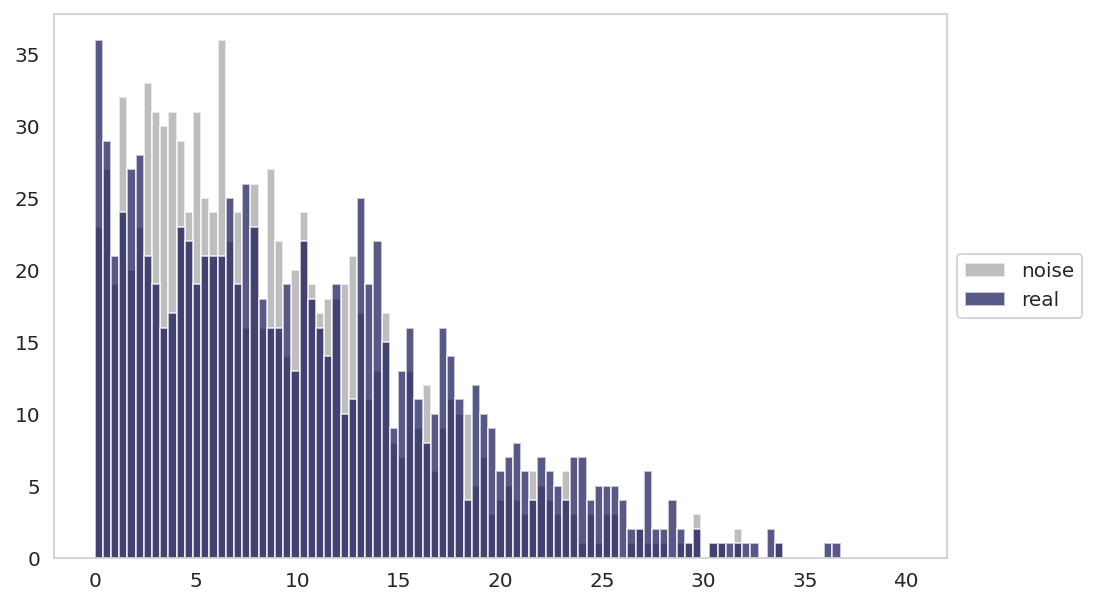

In [70]:
# log permut DBM/OVS
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,40,100)
plt.hist(noise_dbmovs_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(real_dbmovs_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4f_stats_astrneur_log_DBMOVS.svg', transparent=True)
#fig.savefig('../plots/fig4f_stats_astrneur_log_DBMOVS.png',dpi=300, transparent=True)


In [71]:
# sampling

#DBM/OVS

#exp 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['exp_conc']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['exp_conc']


from numpy.random import seed
from numpy.random import randint

noise_dbmovs_val = []
real_dbmovs_val = []

for i in range(1, 1000):
    
    tmpc = get_samples(alltogether, 100, 2)
        
    noise_median1 = np.median(tmpc[0])
    noise_median2 = np.median(tmpc[1])

    noise_lq1 = np.percentile(tmpc[0], 25)  
    noise_uq1 = np.percentile(tmpc[0], 75)  

    noise_lq2 = np.percentile(tmpc[1], 25)  
    noise_uq2 = np.percentile(tmpc[1], 75)  

    noise_dbm = np.abs(noise_median1-noise_median2)
    noise_ovs = np.max([noise_uq1,noise_uq2]) - np.min([noise_lq1,noise_lq2])

    noise_dbmovs = 100*(noise_dbm/noise_ovs)

    
#    
    noise_dbmovs_val.append(noise_dbmovs)
    
##

    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    real_median1 = np.median(sample1)
    real_median2 = np.median(sample2)

    real_lq1 = np.percentile(sample1, 25)  
    real_uq1 = np.percentile(sample1, 75)  

    real_lq2 = np.percentile(sample2, 25)  
    real_uq2 = np.percentile(sample2, 75)  

    real_dbm = np.abs(real_median1-real_median2)
    real_ovs = np.max([real_uq1,real_uq2]) - np.min([real_lq1,real_lq2])

    real_dbmovs = 100*(real_dbm/real_ovs)

#
    real_dbmovs_val.append(real_dbmovs)
    

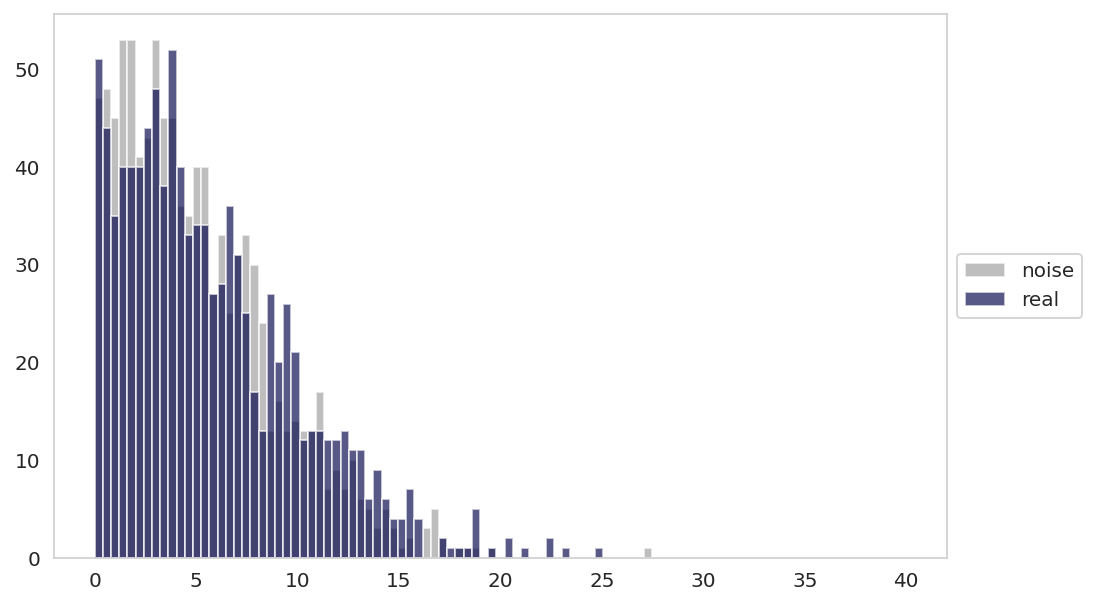

In [72]:
# exp permut DBM/OVS
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,40,100)
plt.hist(noise_dbmovs_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(real_dbmovs_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3C_stats_astrneur_exp_DBMOVS.svg', transparent=True)
#fig.savefig('../plots/S3C_stats_astrneur_exp_DBMOVS.png',dpi=300, transparent=True)


Wilcoxon-Mann-Whitney U test

In [73]:
# sampling

#WMW U

#log 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = mannwhitneyu(tmpc[0], tmpc[1],alternative='two-sided')
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = mannwhitneyu(sample1, sample2,alternative='two-sided')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

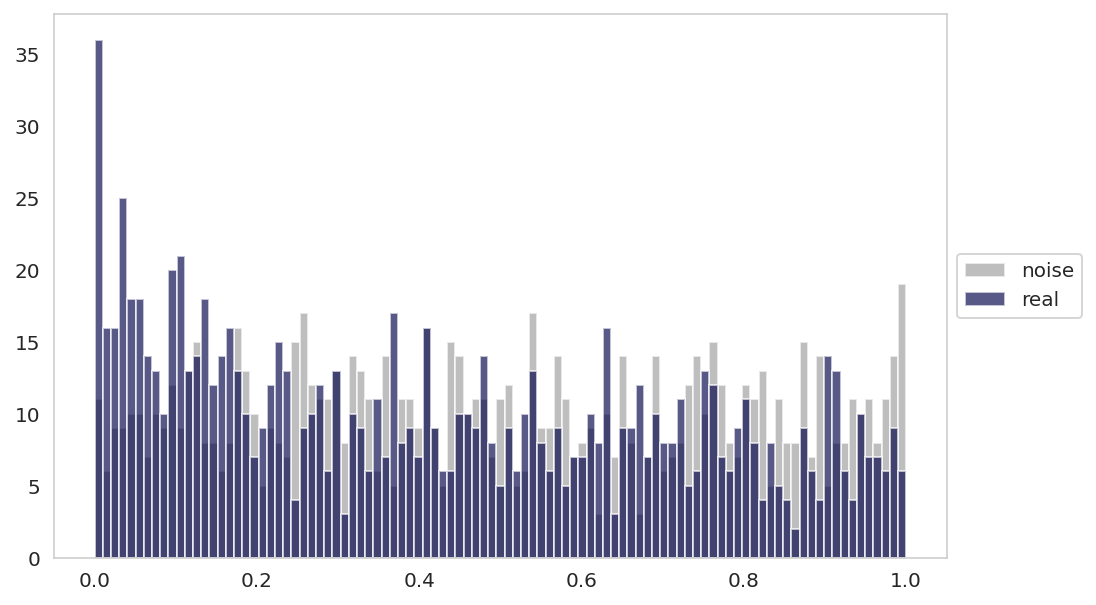

In [74]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4i_stats_astrneur_log_MWU2side_pval.svg', transparent=True)
#fig.savefig('../plots/fig4i_stats_astrneur_log_MWU2side_pval.png',dpi=300, transparent=True)



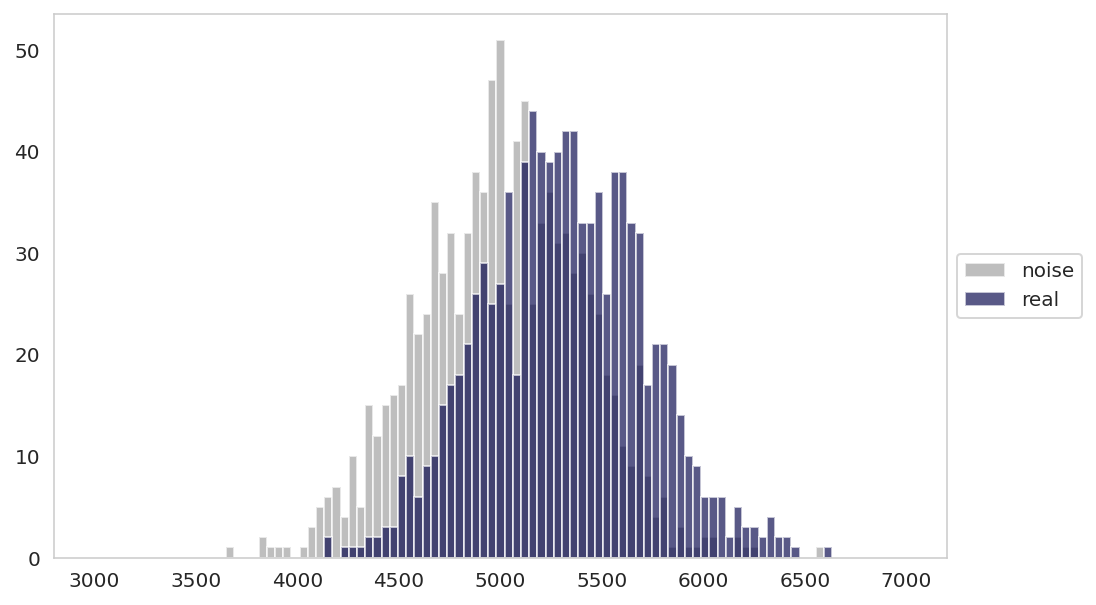

In [75]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(3000,7000,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4i_stats_astrneur_log_MWU2side_val.svg', transparent=True)
#fig.savefig('../plots/fig4i_stats_astrneur_log_MWU2side_val.png',dpi=300, transparent=True)


In [76]:
# sampling

#WMW U

#exp 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['exp_conc']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['exp_conc']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = mannwhitneyu(tmpc[0], tmpc[1],alternative='two-sided')
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = mannwhitneyu(sample1, sample2,alternative='two-sided')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

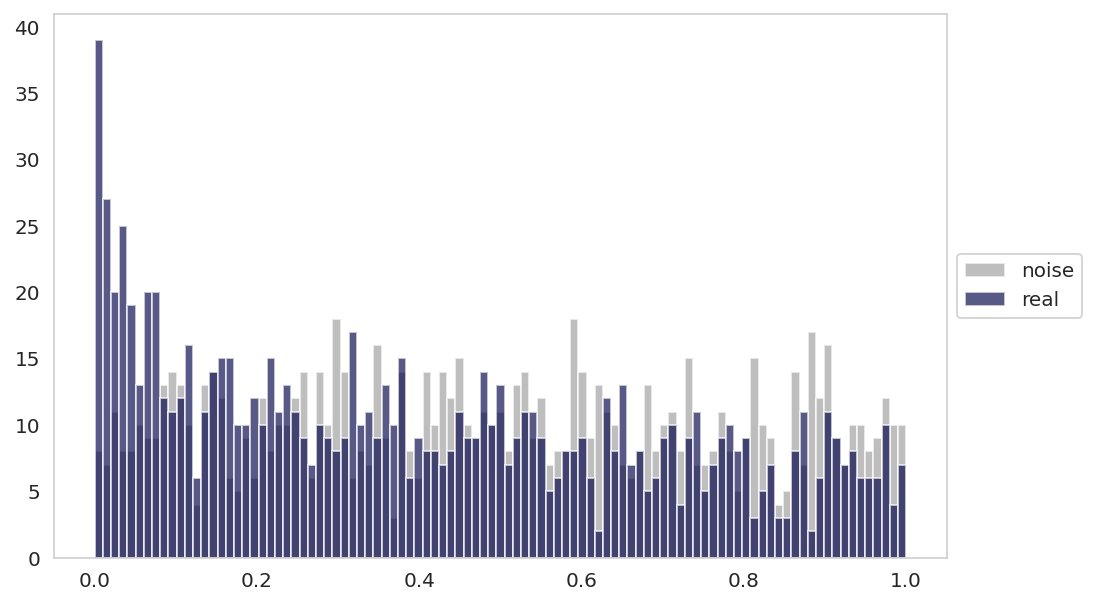

In [77]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3F_stats_astrneur_exp_MWU2side_pval.svg', transparent=True)
#fig.savefig('../plots/S3F_stats_astrneur_exp_MWU2side_pval.png',dpi=300, transparent=True)


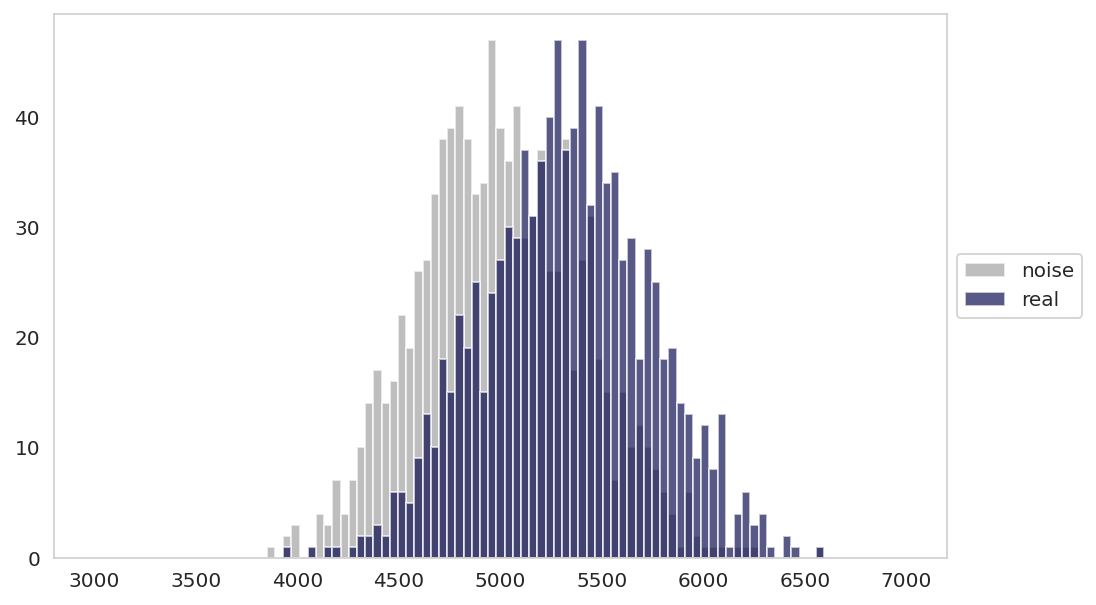

In [78]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(3000,7000,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3F_stats_astrneur_exp_MWU2side_val.svg', transparent=True)
#fig.savefig('../plots/S3F_stats_astrneur_exp_MWU2side_val.png',dpi=300, transparent=True)


KS

In [79]:
# sampling

#KS

#log 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = ks_2samp(tmpc[0], tmpc[1])
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = ks_2samp(sample1, sample2)
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

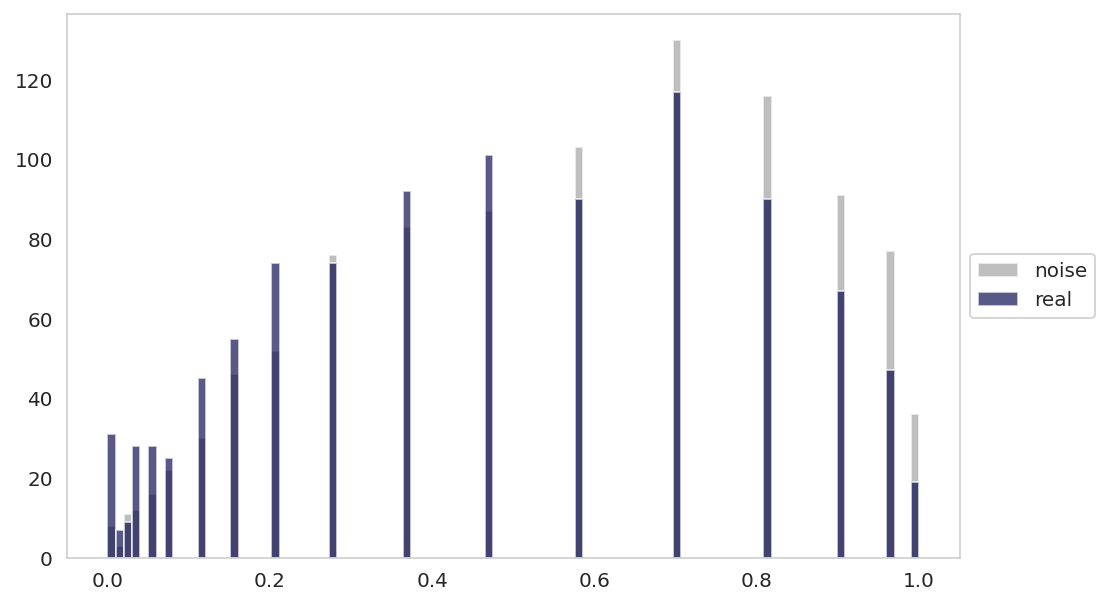

In [80]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4l_stats_astrneur_log_KS2sample_pval.svg', transparent=True)
#fig.savefig('../plots/fig4l_stats_astrneur_log_KS2sample_pval.png', dpi=300, transparent=True)


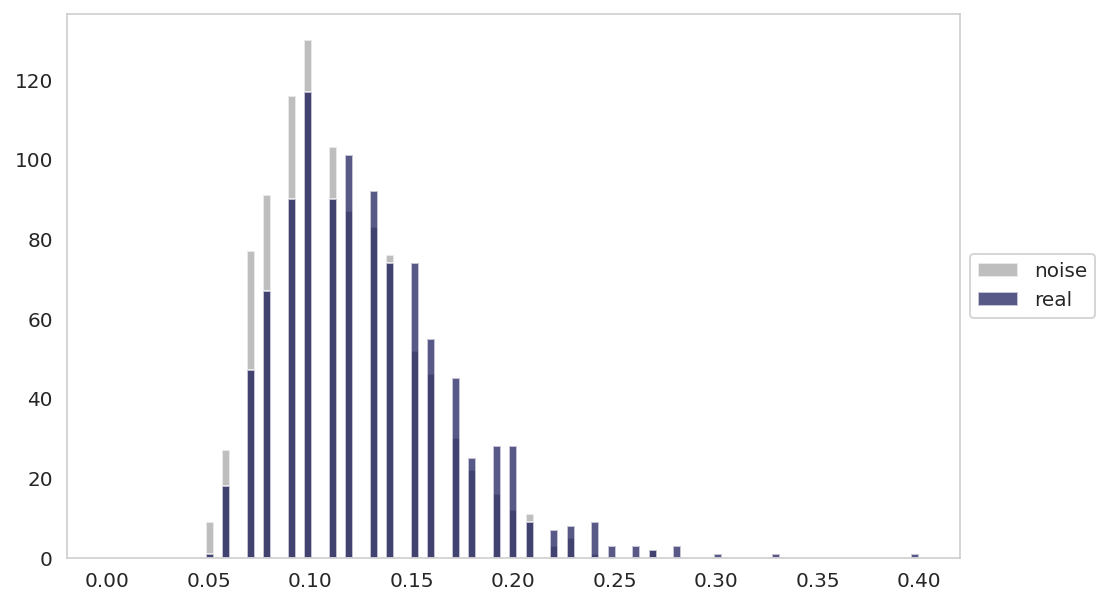

In [81]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,0.4,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4l_stats_astrneur_log_KS2sample_val.svg', transparent=True)
#fig.savefig('../plots/fig4l_stats_astrneur_log_KS2sample_val.png', dpi=300, transparent=True)


In [82]:
# sampling

#KS

#exp 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['exp_conc']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['exp_conc']


from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = ks_2samp(tmpc[0], tmpc[1])
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = ks_2samp(sample1, sample2)
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

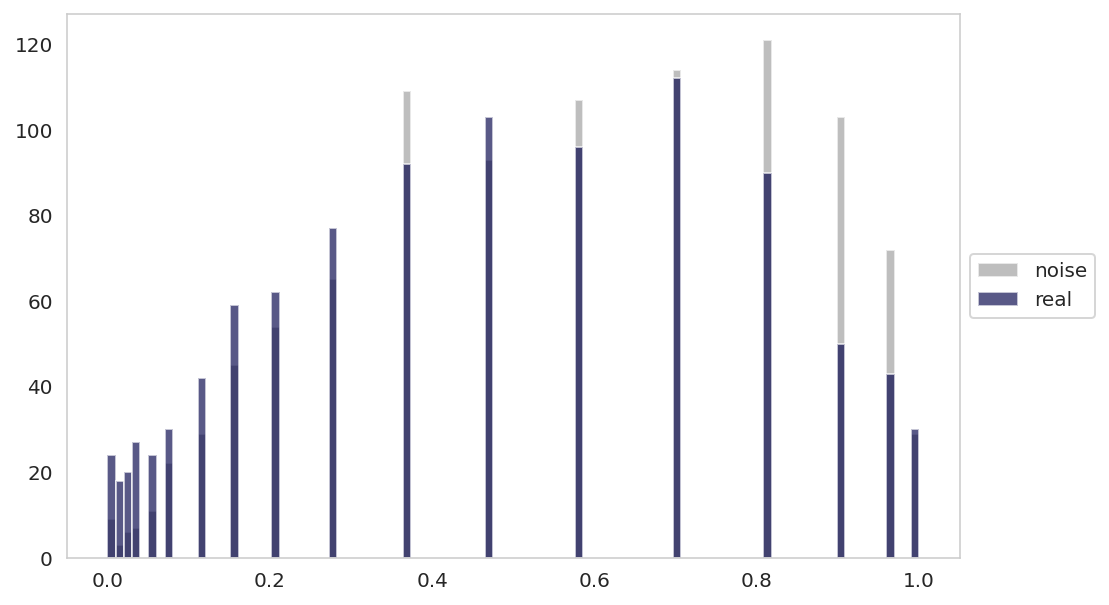

In [83]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3I_stats_astrneur_exp_KS2sample_pval.svg', transparent=True)
#fig.savefig('../plots/S3I_stats_astrneur_exp_KS2sample_pval.png',dpi=300, transparent=True)


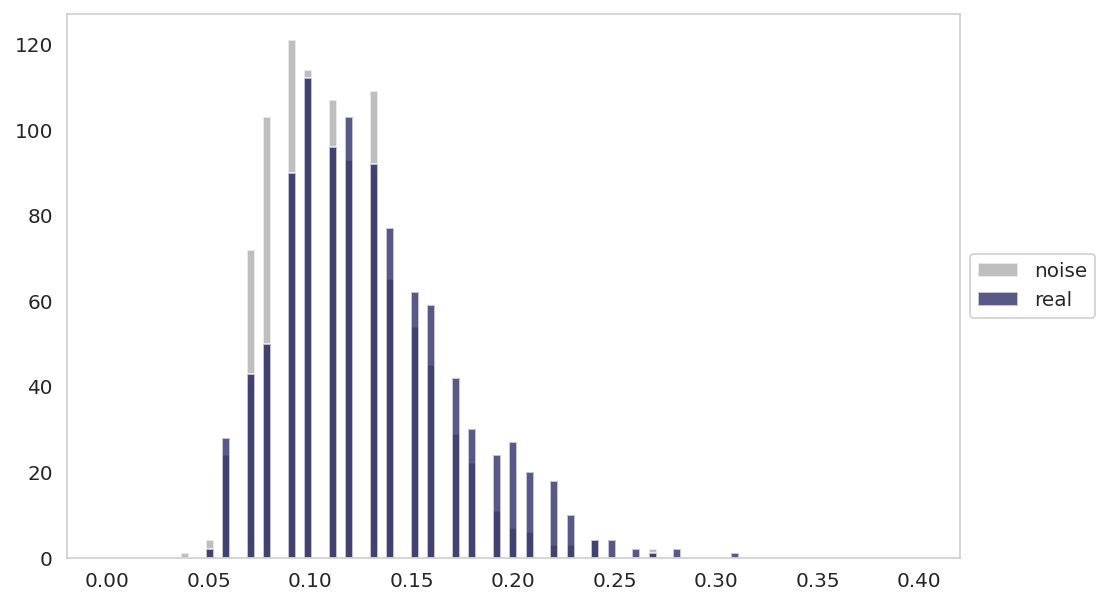

In [84]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,0.4,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3I_stats_astrneur_exp_KS2sample_val.svg', transparent=True)
#fig.savefig('../plots/S3I_stats_astrneur_exp_KS2sample_val.png',dpi=300, transparent=True)


Brown-Forsythe (modified Levene) test for equality of variances

In [85]:
# sampling

#Brown-Forsythe (modified Levene)

#log 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']



from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = levene(tmpc[0], tmpc[1], center='median') 
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = levene(sample1, sample2, center='median') 
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

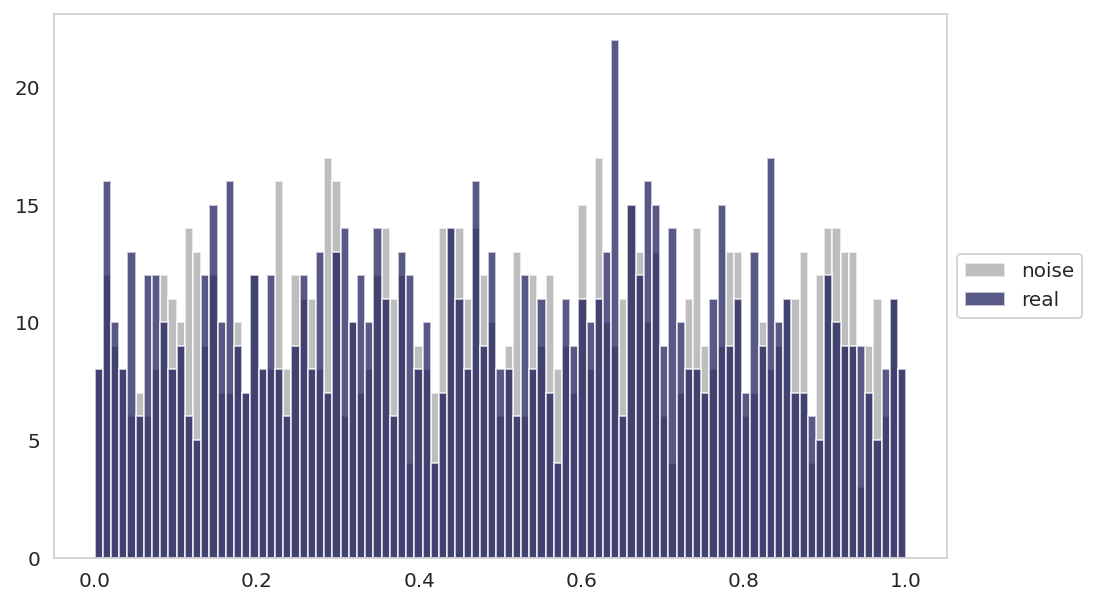

In [86]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4o_stats_astrneur_log_BFLev_pval.svg', transparent=True)
#fig.savefig('../plots/fig4o_stats_astrneur_log_BFLev_pval.png',dpi=300, transparent=True)


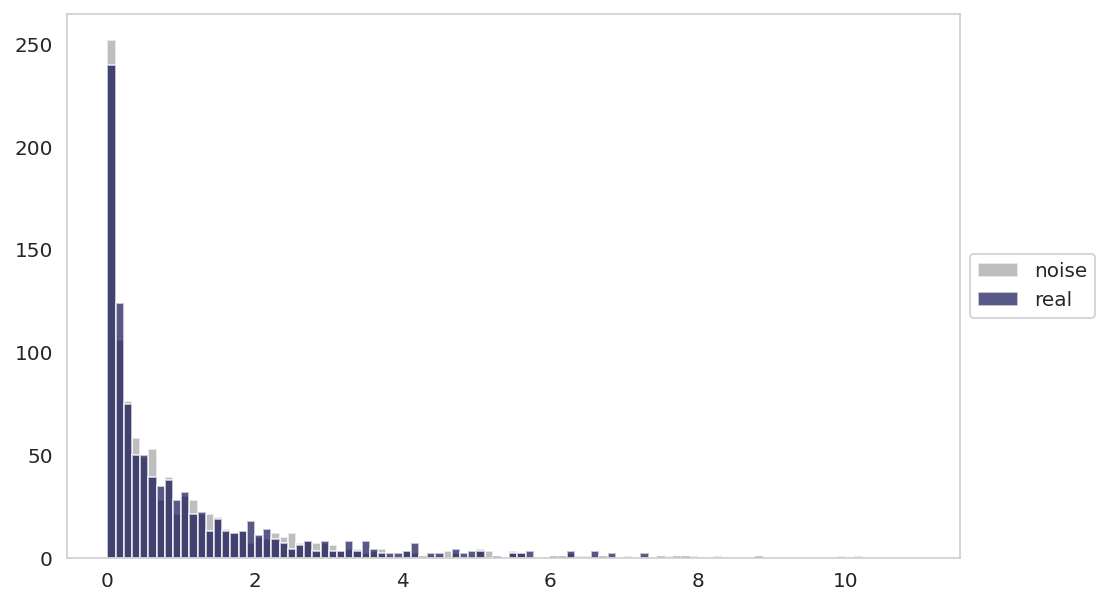

In [87]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/fig4o_stats_astrneur_log_BFLev_val.svg', transparent=True)
#fig.savefig('../plots/fig4o_stats_astrneur_log_BFLev_val.png',dpi=300, transparent=True)


In [88]:
# sampling

#Brown-Forsythe (modified Levene)

#exp 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['exp_conc']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['exp_conc']



from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = levene(tmpc[0], tmpc[1], center='median') 
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = levene(sample1, sample2, center='median') 
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

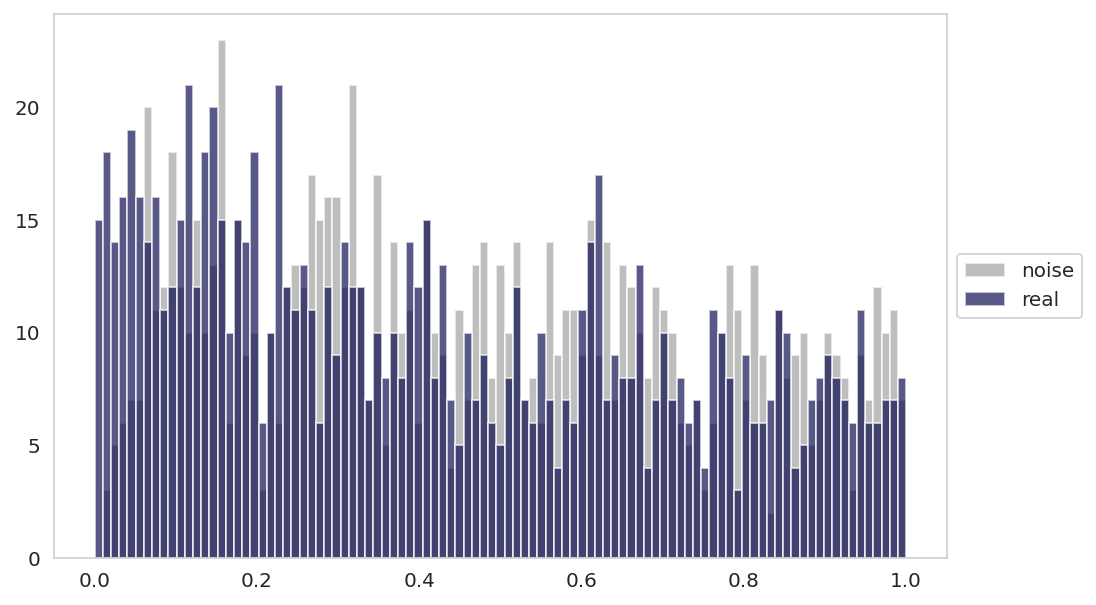

In [89]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3L_stats_astrneur_exp_BFLev_pval.svg', transparent=True)
#fig.savefig('../plots/S3L_stats_astrneur_exp_BFLev_pval.png',dpi=300, transparent=True)


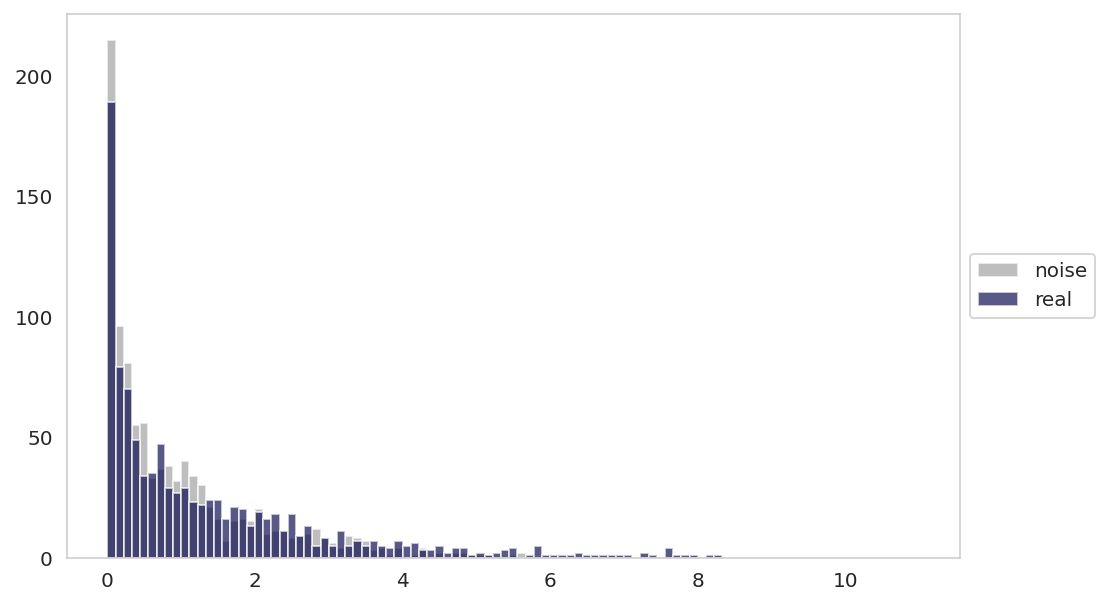

In [90]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/S3L_stats_astrneur_exp_BFLev_val.svg', transparent=True)
#fig.savefig('../plots/S3L_stats_astrneur_exp_BFLev_val.png',dpi=300, transparent=True)


Fligner-Killeen test for equality of variances (non-parametric, median-centered)

In [91]:
# sampling

# Fligner-Killeen test for equality of variances (non-parametric, median-centered)

#log 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['log_conc_uM_medNorm']



from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = fligner(tmpc[0], tmpc[1],center='median')  
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = fligner(sample1, sample2,center='median')  
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

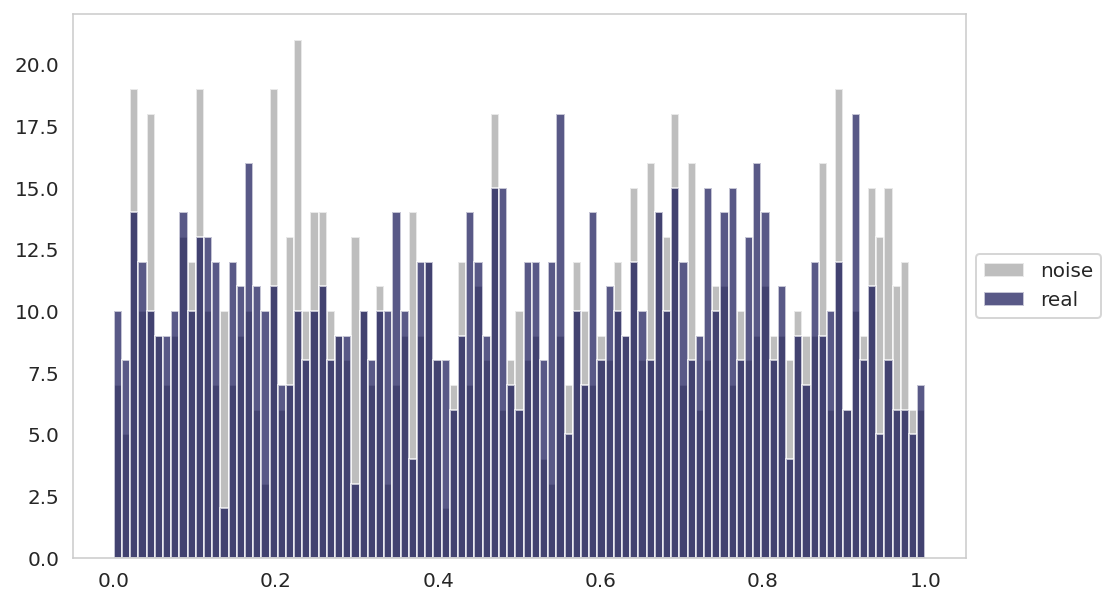

In [92]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4r_stats_astrneur_log_fligner_pval.svg', transparent=True)
#fig.savefig('../plots/fig4r_stats_astrneur_log_fligner_pval.png',dpi=300, transparent=True)


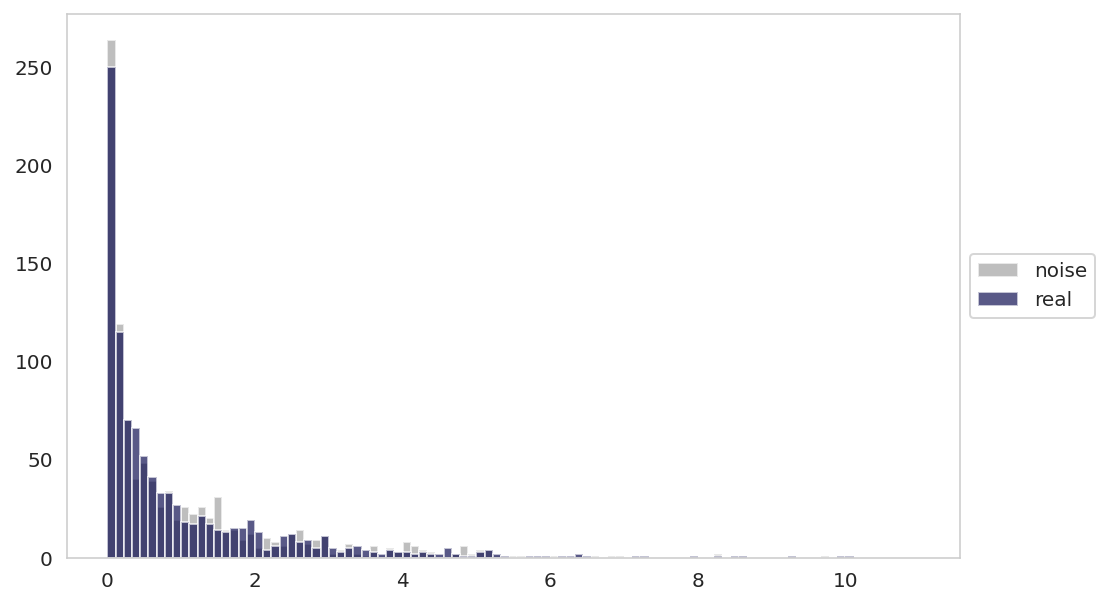

In [93]:
# log
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,11,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)


plt.show()

#fig.savefig('../plots/fig4r_stats_astrneur_log_fligner_val.svg', transparent=True)
#fig.savefig('../plots/fig4r_stats_astrneur_log_fligner_val.png',dpi=300, transparent=True)


In [94]:
# sampling

# Fligner-Killeen test for equality of variances (non-parametric, median-centered)

#exp 
data1 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='astrocytes')& (fun_df['Organism']=='mouse')]['exp_conc']
data2 = fun_df[(fun_df['functional category']=='oxidative stress response')&(fun_df['location']=='neurons')& (fun_df['Organism']=='mouse')]['exp_conc']
alltogether = fun_df[(fun_df['location'].isin(['neurons','astrocytes']))&(fun_df['functional category']=='oxidative stress response')& (fun_df['Organism']=='mouse')]['exp_conc']



from numpy.random import seed
from numpy.random import randint

ks_noise_val = []
ks_noise_pval = []

ks_real_val = []
ks_real_pval = []

for i in range(1, 1000):
    tmpc = get_samples(alltogether, 100, 2)
    
    nvalue, npvalue = fligner(tmpc[0], tmpc[1],center='median')  
    
    ks_noise_val.append(nvalue)
    ks_noise_pval.append(npvalue)
    
    sample1 = get_sample(data1,sample_size=100)
    sample2 = get_sample(data2,sample_size=100)
    
    rvalue, rpvalue = fligner(sample1, sample2,center='median')
    
    
    ks_real_val.append(rvalue)
    ks_real_pval.append(rpvalue)
    

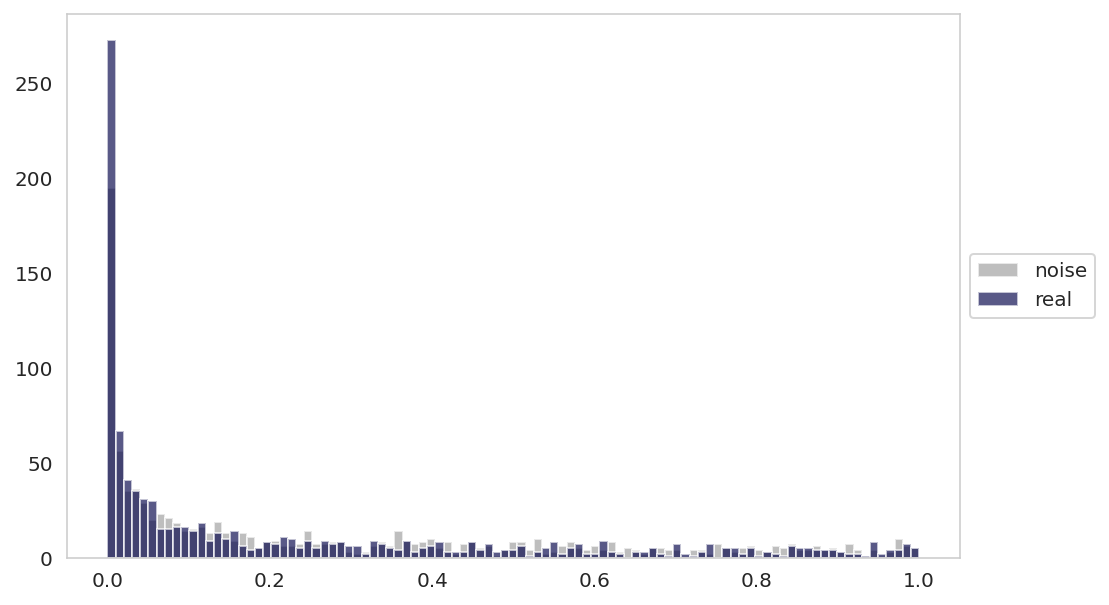

In [95]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(ks_noise_pval,color='#9c9c9c',label='noise',alpha=0.65,bins=bins)
plt.hist(ks_real_pval,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3O_stats_astrneur_exp_fligner_pval.svg', transparent=True)
#fig.savefig('../plots/S3O_stats_astrneur_exp_fligner_pval.png',dpi=300, transparent=True)


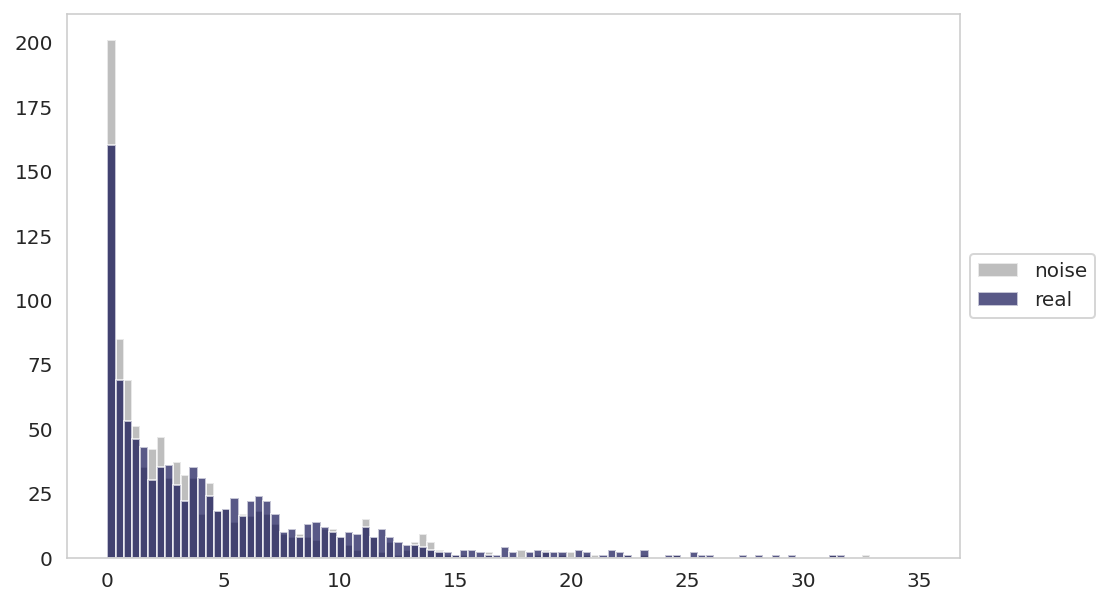

In [96]:
# exp
fig = plt.figure(figsize=(8,5))

bins=np.linspace(0,35,100)
plt.hist(ks_noise_val,color='#9c9c9c',label='noise',alpha=0.65,bins=bins) # ,bins=bins
plt.hist(ks_real_val,color='#000047',label='real',alpha=0.65,bins=bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(b=None)
plt.grid(False)

plt.show()

#fig.savefig('../plots/S3O_stats_astrneur_exp_fligner_val.svg', transparent=True)
#fig.savefig('../plots/S3O_stats_astrneur_exp_fligner_val.png',dpi=300, transparent=True)


In [14]:
fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&
                             (fun_df['location']=='neurons'),'Organism'].unique()

array(['mouse', 'human', 'rat'], dtype=object)

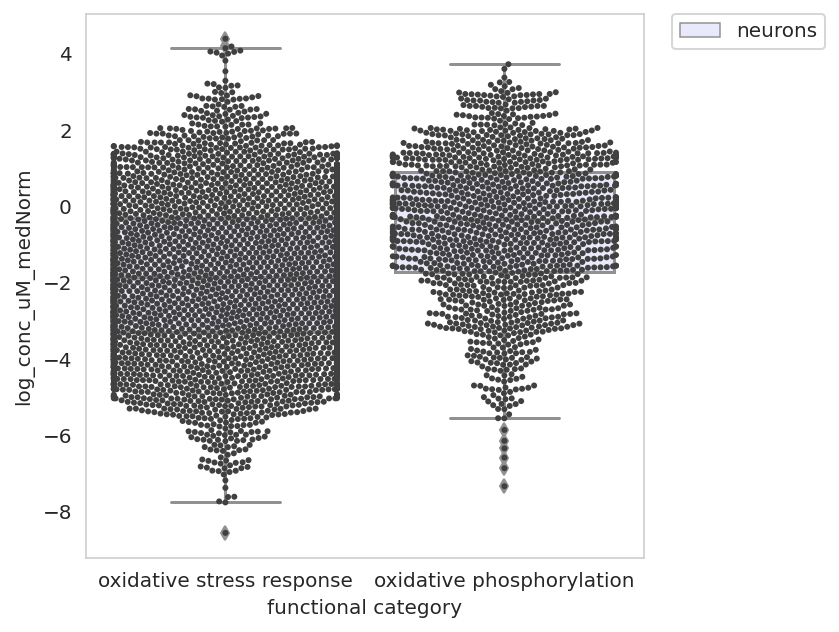

In [97]:
fig,ax = plt.subplots(figsize=(5, 5))

ax = sns.boxplot(x='functional category',y='log_conc_uM_medNorm', 
                 data=fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&
                             (fun_df['location']=='neurons')],
                hue='location',palette=sns.light_palette("navy", reverse=False))
ax = sns.swarmplot(x='functional category',y='log_conc_uM_medNorm',
                   data=fun_df[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&
                               (fun_df['location']=='neurons')], 
                   color=".25", size=3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(False)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()


#fig.savefig('../plots/fig4b_stats_swarm_OSR_OXPHOS.svg', transparent=True)
#fig.savefig('../plots/fig4b_stats_swarm_OSR_OXPHOS.png', dpi=300, transparent=True)



In [98]:
# a
stat1 = fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&
                   (fun_df['location']=='neurons'),['functional category','log_conc_uM_medNorm']].groupby('functional category').describe()

stat1

log_conc_uM_medNorm                                \
                                        count      mean       std       min   
functional category                                                           
DNA repair                             2941.0 -2.406147  2.115261 -8.241623   
oxidative stress response              3624.0 -1.822704  2.039250 -8.568437   

                                                                   
                                25%       50%       75%       max  
functional category                                                
DNA repair                -3.917565 -2.564833 -0.947826  4.697226  
oxidative stress response -3.312831 -1.859545 -0.317624  4.388022

In [17]:
fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&
                   (fun_df['location']=='neurons'),'Organism'].unique()

array(['mouse', 'human', 'rat'], dtype=object)

In [99]:
stat1.iloc[0,4] # 25% ie Q1

-3.9175646777852133

In [100]:
from matplotlib.cbook import boxplot_stats

In [101]:
boxplot_stats(fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response']))&(fun_df['location']=='neurons'),'log_conc_uM_medNorm'])

[{'mean': -1.8227040877492473,
  'iqr': 2.9952074669938877,
  'cilo': -1.9376599680780706,
  'cihi': -1.7814306765511083,
  'whishi': 4.1409661977524514,
  'whislo': -7.769569711974013,
  'fliers': array([-8.56843688,  4.38802201,  4.18440935]),
  'q1': -3.312831494146389,
  'med': -1.8595453223145895,
  'q3': -0.31762402715250143}]

In [102]:
boxplot_stats(fun_df.loc[(fun_df['functional category'].isin(['DNA repair']))&(fun_df['location']=='neurons'),'log_conc_uM_medNorm'])

[{'mean': -2.4061468166175826,
  'iqr': 2.969738215516543,
  'cilo': -2.6508077958957275,
  'cihi': -2.478858538932527,
  'whishi': 3.480263147497455,
  'whislo': -8.24162250351269,
  'fliers': array([3.74346503, 3.56384529, 3.76205575, 3.58246656, 3.61841566,
         4.40119108, 4.56800142, 4.30213732, 3.70919201, 4.3552723 ,
         3.93672257, 3.86606797, 4.44746715, 4.69722597, 4.14697684]),
  'q1': -3.9175646777852133,
  'med': -2.564833167414127,
  'q3': -0.9478264622686705}]

mean	arithmetic mean value
med	50th percentile
q1	first quartile (25th percentile)
q3	third quartile (75th percentile)
cilo	lower notch around the median
cihi	upper notch around the median
whislo	end of the lower whisker
whishi	end of the upper whisker
fliers	outliers

In [103]:
from matplotlib.cbook import boxplot_stats
#a OSR left
boxdata = fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response']))&(fun_df['location']=='neurons'),'log_conc_uM_medNorm']

boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 


print("center line, median: ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

center line, median:  -1.86 ;  upper and lower quartiles: Q1: -3.31 , Q3:  -0.32 ;  whiskers, 1.5x interquartile range:  -7.77 ,  4.14 ;  outliers:  [-8.56843688  4.38802201  4.18440935]


In [104]:
#a DNA rep right
boxdata = fun_df.loc[(fun_df['functional category'].isin(['DNA repair']))&(fun_df['location']=='neurons'),'log_conc_uM_medNorm']

boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 


print("center line, median: ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

center line, median:  -2.56 ;  upper and lower quartiles: Q1: -3.92 , Q3:  -0.95 ;  whiskers, 1.5x interquartile range:  -8.24 ,  3.48 ;  outliers:  [3.74346503 3.56384529 3.76205575 3.58246656 3.61841566 4.40119108
 4.56800142 4.30213732 3.70919201 4.3552723  3.93672257 3.86606797
 4.44746715 4.69722597 4.14697684]


In [105]:
#b OSR left
boxdata = fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response']))&(fun_df['location']=='neurons'),'log_conc_uM_medNorm']

boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 


print("center line, median: ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

center line, median:  -1.86 ;  upper and lower quartiles: Q1: -3.31 , Q3:  -0.32 ;  whiskers, 1.5x interquartile range:  -7.77 ,  4.14 ;  outliers:  [-8.56843688  4.38802201  4.18440935]


In [106]:
#b OXPHOS right
boxdata = fun_df.loc[(fun_df['functional category'].isin(['oxidative phosphorylation']))&(fun_df['location']=='neurons'),'log_conc_uM_medNorm']

boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 


print("center line, median: ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

center line, median:  -0.35 ;  upper and lower quartiles: Q1: -1.74 , Q3:  0.90 ;  whiskers, 1.5x interquartile range:  -5.56 ,  3.72 ;  outliers:  [-7.34444626 -5.86804296 -6.35330555 -6.15458369 -6.59324614 -6.87282758]


In [107]:
#c astro left
boxdata = fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response']))&(fun_df['location'].isin(['astrocytes']))&
                     (fun_df['Organism']=='mouse'),'log_conc_uM_medNorm']

boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 


print("center line, median: ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

center line, median:  -1.74 ;  upper and lower quartiles: Q1: -3.17 , Q3:  0.00 ;  whiskers, 1.5x interquartile range:  -7.93 ,  4.43 ;  outliers:  []


In [108]:
#c neuro right
boxdata = fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response']))&(fun_df['location'].isin(['neurons']))&
                     (fun_df['Organism']=='mouse'),'log_conc_uM_medNorm']


boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 


print("center line, median: ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

center line, median:  -1.96 ;  upper and lower quartiles: Q1: -3.44 , Q3:  -0.26 ;  whiskers, 1.5x interquartile range:  -7.63 ,  4.39 ;  outliers:  [-8.56843688]


In [109]:
# b
fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&
           (fun_df['location']=='neurons'),['functional category','log_conc_uM_medNorm']].groupby('functional category').describe()

log_conc_uM_medNorm                                \
                                        count      mean       std       min   
functional category                                                           
oxidative phosphorylation              1318.0 -0.524964  1.905938 -7.344446   
oxidative stress response              3624.0 -1.822704  2.039250 -8.568437   

                                                                   
                                25%       50%       75%       max  
functional category                                                
oxidative phosphorylation -1.737753 -0.347910  0.898958  3.719032  
oxidative stress response -3.312831 -1.859545 -0.317624  4.388022

In [16]:
fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response','oxidative phosphorylation']))&
           (fun_df['location']=='neurons'),'Organism'].unique()

array(['mouse', 'human', 'rat'], dtype=object)

In [110]:
# c
fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response']))&
       (fun_df['location'].isin(['neurons','astrocytes']))& (fun_df['Organism']=='mouse'),['location','log_conc_uM_medNorm']].groupby('location').describe()

log_conc_uM_medNorm                                          \
                         count      mean       std       min       25%   
location                                                                 
astrocytes              2590.0 -1.642500  2.156536 -7.928084 -3.172400   
neurons                 2166.0 -1.870103  2.082467 -8.568437 -3.444343   

                                          
                 50%       75%       max  
location                                  
astrocytes -1.737866  0.000777  4.433237  
neurons    -1.958971 -0.263767  4.388022

In [112]:
len(fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')&
           (fun_df['functional category']=='oxidative stress response')])

3624

In [113]:
len(fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')&
           (fun_df['functional category']=='DNA repair')])

2941

In [13]:
fun_df.loc[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons'),'Organism'].unique()

array(['mouse', 'human', 'rat'], dtype=object)

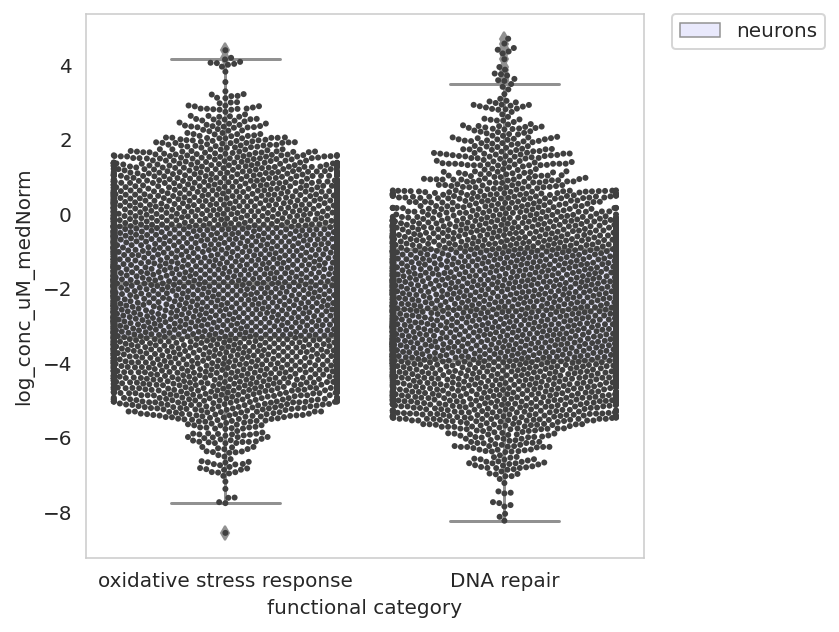

In [114]:
fig,ax = plt.subplots(figsize=(5, 5))

ax = sns.boxplot(x='functional category',y='log_conc_uM_medNorm', 
                 data=fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')],
                hue='location',palette=sns.light_palette("navy", reverse=False))

ax = sns.swarmplot(x='functional category',y='log_conc_uM_medNorm',data=fun_df[(fun_df['functional category'].isin(['oxidative stress response','DNA repair']))&(fun_df['location']=='neurons')],
                   color=".25",size=3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(False)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

#fig.savefig('../plots/fig4a_stats_swarm_OSRDNArepair.svg', transparent=True)
#fig.savefig('../plots/fig4a_stats_swarm_OSRDNArepair.png', dpi=300, transparent=True)


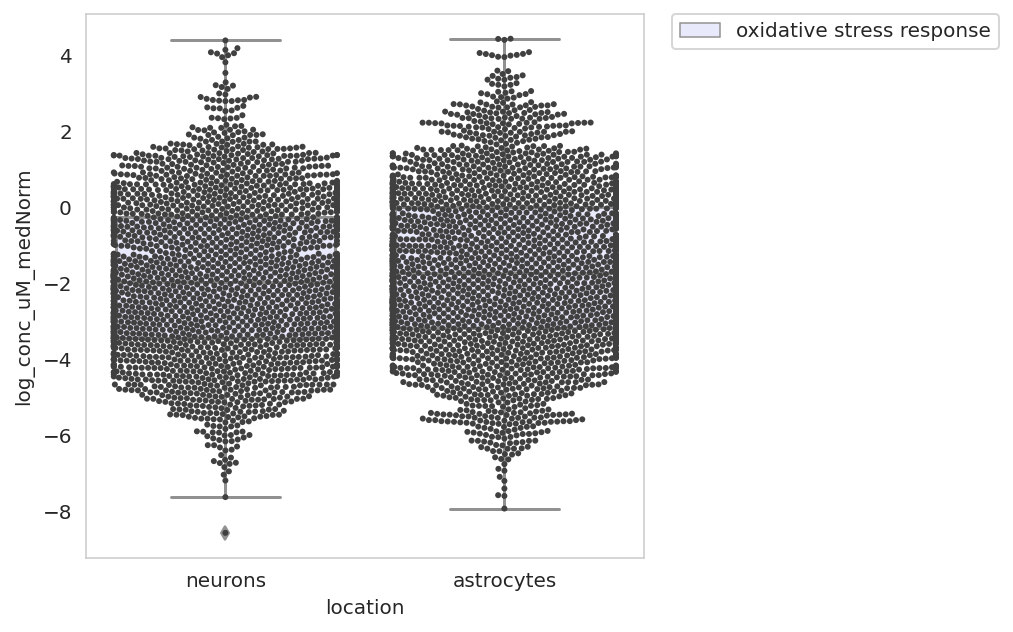

In [115]:
fig,ax = plt.subplots(figsize=(5, 5))

ax = sns.boxplot(x='location',y='log_conc_uM_medNorm', 
                 data=fun_df[(fun_df['functional category'].isin(['oxidative stress response']))&
                             (fun_df['location'].isin(['neurons','astrocytes']))&
                             (fun_df['Organism']=='mouse')],
                hue='functional category',palette=sns.light_palette("navy", reverse=False),order=['neurons','astrocytes'])

ax = sns.swarmplot(x='location',y='log_conc_uM_medNorm',data=fun_df[(fun_df['functional category'].isin(['oxidative stress response']))&
                                                                    (fun_df['location'].isin(['neurons','astrocytes']))&
                             (fun_df['Organism']=='mouse')], 
                   color=".25", size=3,order=['neurons','astrocytes'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(False)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.show()

#fig.savefig('../plots/fig4c_stats_swarm_NA.svg', transparent=True)
#fig.savefig('../plots/fig4c_stats_swarm_NA.png', dpi=300, transparent=True)

